# Проект e-commerce: вариант 1 
### Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.



#### Файлы:

1. olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей

* customer_id — позаказный идентификатор пользователя

* customer_unique_id —  уникальный идентификатор пользователя  (аналог номера паспорта)

* customer_zip_code_prefix —  почтовый индекс пользователя

* customer_city —  город доставки пользователя

* customer_state —  штат доставки пользователя

2. olist_orders_dataset.csv —  таблица заказов

* order_id —  уникальный идентификатор заказа (номер чека)

* customer_id —  позаказный идентификатор пользователя

* order_status —  статус заказа

* order_purchase_timestamp —  время создания заказа

* order_approved_at —  время подтверждения оплаты заказа

* order_delivered_carrier_date —  время передачи заказа в логистическую службу

* order_delivered_customer_date —  время доставки заказа

* order_estimated_delivery_date —  обещанная дата доставки

3. olist_order_items_dataset.csv —  товарные позиции, входящие в заказы

* order_id —  уникальный идентификатор заказа (номер чека)

* order_item_id —  идентификатор товара внутри одного заказа

* product_id —  ид товара (аналог штрихкода)

* seller_id — ид производителя товара

* shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

* price —  цена за единицу товара

* freight_value —  вес товара

— Пример структуры данных можно визуализировать по order_id == 00143d0f86d6fbd9f9b38ab440ac16f5

Уникальные статусы заказов в таблице olist_orders_dataset:

* created —  создан
* approved —  подтверждён
* invoiced —  выставлен счёт
* processing —  в процессе сборки заказа
* shipped —  отгружен со склада
* delivered —  доставлен пользователю
* unavailable —  недоступен
* canceled —  отменён

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tseries.offsets import MonthEnd
from operator import attrgetter
from datetime import timedelta

In [2]:
customers=pd.read_csv('C:/Users/anna1/Desktop/Test Jupyter/my_project_from_karpov/olist_customers_dataset.csv')
orders=pd.read_csv('C:/Users/anna1/Desktop/Test Jupyter/my_project_from_karpov/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
items=pd.read_csv('C:/Users/anna1/Desktop/Test Jupyter/my_project_from_karpov/olist_order_items_dataset.csv',  parse_dates=['shipping_limit_date'])

In [3]:
# Покупкой считается оплаченный заказ 
# Для некоторых расчетов будем использовать общую таблицу all_orders

In [4]:
orders_buy = orders.query( "order_approved_at!='NaT'" )
orders_buy

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15


In [5]:
#Для заданий 3 и 5 оставим смердженную таблицу, а также для Monetary в последнем задании
all_orders = orders_buy.merge( customers, how = 'inner', on = 'customer_id' )
all_orders = all_orders.merge( items, how = 'inner', on = 'order_id' )
all_orders

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112630,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10
112631,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02
112632,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59
112633,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59


### 1 Сколько у нас пользователей, которые совершили покупку только один раз? 


In [6]:
#Объединим customers и orders_buy, далее сгруппируем по уникальному значению пользователя (паспорту) и посчитаем количество 
#уникальных заказов для каждого пользователя, выведем общее количество пользователей, которые совершили один заказ

all_orders_ = orders_buy.merge( customers, how = 'inner', on = 'customer_id' )
customer_id_delivery = all_orders_.groupby( 'customer_unique_id', as_index = False )\
                            .agg( {'order_id':'nunique'} ).rename(columns = {'order_id':'count_order_id'})
customer_id_delivery.query( 'count_order_id == 1' ).shape[0]

93049

In [7]:
#Посчитаем процент пользователей, которые совершили только одн покупку
round((customer_id_delivery.query( 'count_order_id == 1' ).shape[0]/all_orders_.customer_unique_id.nunique()*100), 2)

96.93

In [8]:
#Значительная часть пользователей совершили покупки только один раз. Возможно в компании активно занимаются поиском новых клиентов
#из-за чего упускают прибыль с повторных продаж.

### 2 Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [9]:
#В данной задаче рассматриваем только заказы с фактом покупки, что считается покупкой было принято выше

In [10]:
#Рассмотрим несколько вариантов
#1 Рассмотрим вариант, когда статус заказ отличается от "delivered", но фактическа дата заказа указана. Таких заказов немного из 
# выборки это 6 заказов, скорей всего, они были доставлены, но был оформлен возврат, поэтому общий статус заказа "canceled"
#но по факту доставка совершена

In [11]:
orders_buy.query( "order_delivered_customer_date!='NaT' & order_status!='delivered'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09
8791,dabf2b0e35b423f94618bf965fcb7514,5cdec0bb8cbdf53ffc8fdc212cd247c6,canceled,2016-10-09 00:56:52,2016-10-09 13:36:58,2016-10-13 13:36:59,2016-10-16 14:36:59,2016-11-30
58266,770d331c84e5b214bd9dc70a10b829d0,6c57e6119369185e575b36712766b0ef,canceled,2016-10-07 14:52:30,2016-10-07 15:07:10,2016-10-11 15:07:11,2016-10-14 15:07:11,2016-11-29
59332,8beb59392e21af5eb9547ae1a9938d06,bf609b5741f71697f65ce3852c5d2623,canceled,2016-10-08 20:17:50,2016-10-09 14:34:30,2016-10-14 22:45:26,2016-10-19 18:47:43,2016-11-30
92636,65d1e226dfaeb8cdc42f665422522d14,70fc57eeae292675927697fe03ad3ff5,canceled,2016-10-03 21:01:41,2016-10-04 10:18:57,2016-10-25 12:14:28,2016-11-08 10:58:34,2016-11-25
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08


In [12]:
#2 Еще один вариант, когда статус "delivered", но не указан фактическое время доставки, возможно это баг или пользователь не указал, 
# что заказ доставлен, либо пользователь просто не получил заказ. Доставлен ли точно заказ или нет нам неизсестно

In [13]:
orders_buy.query( "order_delivered_customer_date=='NaT' & order_status=='delivered'")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
3002,2d1e2d5bf4dc7227b3bfebb81328c15f,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23,NaT,2017-12-18
20618,f5dd62b788049ad9fc0526e3ad11a097,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00,NaT,2018-07-16
43834,2ebdfc4f15f23b91474edf87475f108e,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00,NaT,2018-07-30
79263,e69f75a717d64fc5ecdfae42b2e8e086,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00,NaT,2018-07-30
82868,0d3268bad9b086af767785e3f0fc0133,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00,NaT,2018-07-24
92643,2d858f451373b04fb5c984a1cc2defaf,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23
97647,ab7c89dc1bf4a1ead9d6ec1ec8968a84,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00,NaT,2018-06-26
98038,20edc82cf5400ce95e1afacc25798b31,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00,NaT,2018-07-19


In [14]:
#3 Рассмотрим вариант, когда статус заказа отличается от "delivered" или нет даты доставки. С ним и будем работать

In [15]:
orders_no_delivered = orders_buy.query( "order_delivered_customer_date=='NaT' | order_status!='delivered'")

In [16]:
orders_no_delivered

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09
44,ee64d42b8cf066f35eac1cf57de1aa85,caded193e8e47b8362864762a83db3c5,shipped,2018-06-04 16:44:48,2018-06-05 04:31:18,2018-06-05 14:32:00,NaT,2018-06-28
103,0760a852e4e9d89eb77bf631eaaf1c84,d2a79636084590b7465af8ab374a8cf5,invoiced,2018-08-03 17:44:42,2018-08-07 06:15:14,NaT,NaT,2018-08-21
128,15bed8e2fec7fdbadb186b57c46c92f2,f3f0e613e0bdb9c7cee75504f0f90679,processing,2017-09-03 14:22:03,2017-09-03 14:30:09,NaT,NaT,2017-10-03
154,6942b8da583c2f9957e990d028607019,52006a9383bf149a4fb24226b173106f,shipped,2018-01-10 11:33:07,2018-01-11 02:32:30,2018-01-11 19:39:23,NaT,2018-02-07
...,...,...,...,...,...,...,...,...
99233,1c7c8ab324927f5b6e52338bd110bef4,95b1767df51d6fa09402267d8de314df,unavailable,2017-12-23 18:48:09,2017-12-23 18:54:22,NaT,NaT,2018-01-19
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaT,NaT,2018-02-06
99313,e9e64a17afa9653aacf2616d94c005b8,b4cd0522e632e481f8eaf766a2646e86,processing,2018-01-05 23:07:24,2018-01-09 07:18:05,NaT,NaT,2018-02-06
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaT,NaT,2017-09-15


In [17]:
#2.1 Заказ отменен, но оплачен и не передан в логистику 
#(возможно причина в отсутствии товара на складе или отмене по желанию покупателя)

In [18]:
#Посчитаем количество недоставленных заказов сгруппировав по обещанной дате доставки по вышезаданным условиям

orders_no_delivered_by_day_1 = orders_no_delivered.query("order_status=='canceled' & order_approved_at!='NaT' & order_delivered_carrier_date=='NaT' & order_delivered_customer_date=='NaT'")\
    .groupby('order_estimated_delivery_date', as_index = False)\
    .agg({'order_id':'nunique'})
orders_no_delivered_by_day_1 = orders_no_delivered_by_day_1.set_index( 'order_estimated_delivery_date' )
orders_no_delivered_mean_month_1 = orders_no_delivered_by_day_1.resample(rule = 'M')\
    .sum()\
    .rename(columns = {'order_id':'sum_orders_canceled_approved'}).reset_index().dropna()
orders_no_delivered_mean_month_1

,order_estimated_delivery_date,sum_orders_canceled_approved
0,2016-09-30,1
1,2016-10-31,2
2,2016-11-30,5
3,2016-12-31,7
4,2017-01-31,0
5,2017-02-28,1
6,2017-03-31,24
7,2017-04-30,20
8,2017-05-31,15
9,2017-06-30,23


In [19]:
#2.2 Заказ не отменен, оплачен, и передан в логистическую службу
#(возможная причина - потеря товара в пути или покупатель не подтвердил факт получения товара, хотя товар доставлен)

In [20]:
#Посчитаем количество недоставленных заказов сгруппировав по обещанной дате доставки по вышезаданным условиям

orders_no_delivered_by_day_2 = orders_no_delivered.query("order_status!='canceled' & order_approved_at!='NaT' & order_delivered_carrier_date!='NaT' & order_delivered_customer_date=='NaT'")\
    .groupby('order_estimated_delivery_date', as_index = False)\
    .agg({'order_id':'nunique'})
orders_no_delivered_by_day_2 = orders_no_delivered_by_day_2.set_index( 'order_estimated_delivery_date' )
orders_no_delivered_mean_month_2 = orders_no_delivered_by_day_2.resample(rule = 'M')\
    .sum()\
    .rename(columns = {'order_id':'sum_orders_in_logistic'}).reset_index().dropna()
orders_no_delivered_mean_month_2

,order_estimated_delivery_date,sum_orders_in_logistic
0,2016-10-31,1
1,2016-11-30,1
2,2016-12-31,7
3,2017-01-31,0
4,2017-02-28,6
5,2017-03-31,41
6,2017-04-30,35
7,2017-05-31,60
8,2017-06-30,52
9,2017-07-31,51


In [21]:
#2.3 Заказ не отменен, оплачен, но не передан в логистическую службу
#(возможная причина - отсутстсвие товара на складе или проблемы у продавца с логистической фирмой)

In [22]:
#Посчитаем количество недоставленных заказов сгруппировав по обещанной дате доставки по вышезаданным условиям
orders_no_delivered_by_day_3 = orders_no_delivered.query("order_status!='canceled' & order_approved_at!='NaT' & order_delivered_carrier_date=='NaT' & order_delivered_customer_date=='NaT'")\
    .groupby('order_estimated_delivery_date', as_index = False)\
    .agg({'order_id':'nunique'})
orders_no_delivered_by_day_3 = orders_no_delivered_by_day_3.set_index( 'order_estimated_delivery_date' )
orders_no_delivered_mean_month_3 = orders_no_delivered_by_day_3.resample(rule = 'M')\
    .sum()\
    .rename(columns = {'order_id':'sum_orders_pay_no_logistic'}).reset_index().dropna()
orders_no_delivered_mean_month_3

,order_estimated_delivery_date,sum_orders_pay_no_logistic
0,2016-11-30,14
1,2016-12-31,13
2,2017-01-31,0
3,2017-02-28,4
4,2017-03-31,126
5,2017-04-30,47
6,2017-05-31,48
7,2017-06-30,63
8,2017-07-31,57
9,2017-08-31,67


In [23]:
#2.4 Объединение df по причинам недоставки заказов
#Также добавлен столбец со общим количеством заказов по месяцам 
#и с процентными сотношениями количества недоставленных и доставленных товаров

In [24]:
orders_by_day = orders_buy\
    .groupby('order_estimated_delivery_date', as_index = False)\
    .agg({'order_id':'nunique'})
orders_by_day = orders_by_day.set_index( 'order_estimated_delivery_date' )
orders_mean_month = orders_by_day.resample(rule = 'M')\
    .sum()\
    .rename(columns = {'order_id':'sum_orders'}).reset_index().dropna()
orders_mean_month

,order_estimated_delivery_date,sum_orders
0,2016-09-30,1
1,2016-10-31,5
2,2016-11-30,166
3,2016-12-31,148
4,2017-01-31,3
5,2017-02-28,315
6,2017-03-31,2785
7,2017-04-30,2233
8,2017-05-31,3029
9,2017-06-30,3633


In [25]:
#Объединим ве таблицы по обещанной дате доставки, заменив пропущенные значения 0^
#order_estimated_delivery_date - обещанная дата доставки
#sum_orders_canceled_approved - Заказ отменен, но оплачен и не передан в логистику 
#sum_orders_in_logistic - Заказ не отменен, оплачен, и передан в логистическую службу
#sum_orders_pay_no_logistic - Заказ не отменен, оплачен, но не передан в логистическую службу
#sum_orders - суммарное кол-во заказов 

df = pd.merge(orders_no_delivered_mean_month_1, orders_no_delivered_mean_month_2, how = 'outer')
df = pd.merge(df, orders_no_delivered_mean_month_3, how = 'outer')
orders_no_delivered_by_reason = pd.merge(df, orders_mean_month, how = 'outer').fillna(0)\
    .sort_values('order_estimated_delivery_date')
orders_no_delivered_by_reason

,order_estimated_delivery_date,sum_orders_canceled_approved,sum_orders_in_logistic,sum_orders_pay_no_logistic,sum_orders
0,2016-09-30,1.0,0.0,0.0,1
1,2016-10-31,2.0,1.0,0.0,5
2,2016-11-30,5.0,1.0,14.0,166
3,2016-12-31,7.0,7.0,13.0,148
4,2017-01-31,0.0,0.0,0.0,3
5,2017-02-28,1.0,6.0,4.0,315
6,2017-03-31,24.0,41.0,126.0,2785
7,2017-04-30,20.0,35.0,47.0,2233
8,2017-05-31,15.0,60.0,48.0,3029
9,2017-06-30,23.0,52.0,63.0,3633


In [26]:
#посчитаем процент недоставленных заказов для кадой причины оносительной общей суммы заказов
orders_no_delivered_by_reason['orders_canceled_approved'] = orders_no_delivered_by_reason.sum_orders_canceled_approved/orders_no_delivered_by_reason.sum_orders*100
orders_no_delivered_by_reason['orders_in_logistic'] = orders_no_delivered_by_reason.sum_orders_in_logistic/orders_no_delivered_by_reason.sum_orders*100
orders_no_delivered_by_reason['orders_pay_no_logistic'] = orders_no_delivered_by_reason.sum_orders_pay_no_logistic/orders_no_delivered_by_reason.sum_orders*100

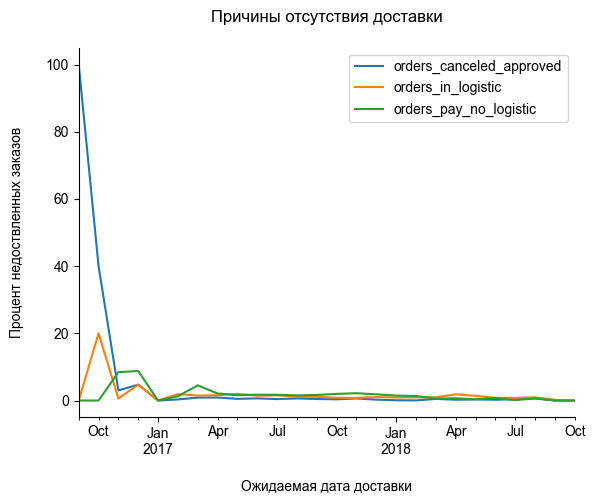

In [27]:
#Построим график зависимости процента недоставленных заказов от обещанной даты доставки
a = orders_no_delivered_by_reason.drop(columns = ['sum_orders', 'sum_orders_canceled_approved', 'sum_orders_in_logistic', 'sum_orders_pay_no_logistic'])
a = a.set_index('order_estimated_delivery_date')
ax = a.plot()
ax.set_title('Причины отсутствия доставки\n') #название графика с пропуском строки
ax.set_xlabel('\nОжидаемая дата доставки') #газвание осей
ax.set_ylabel('Процент недоствленных заказов\n')
sns.set(rc = {'figure.figsize':(20,20)})

sns.despine()

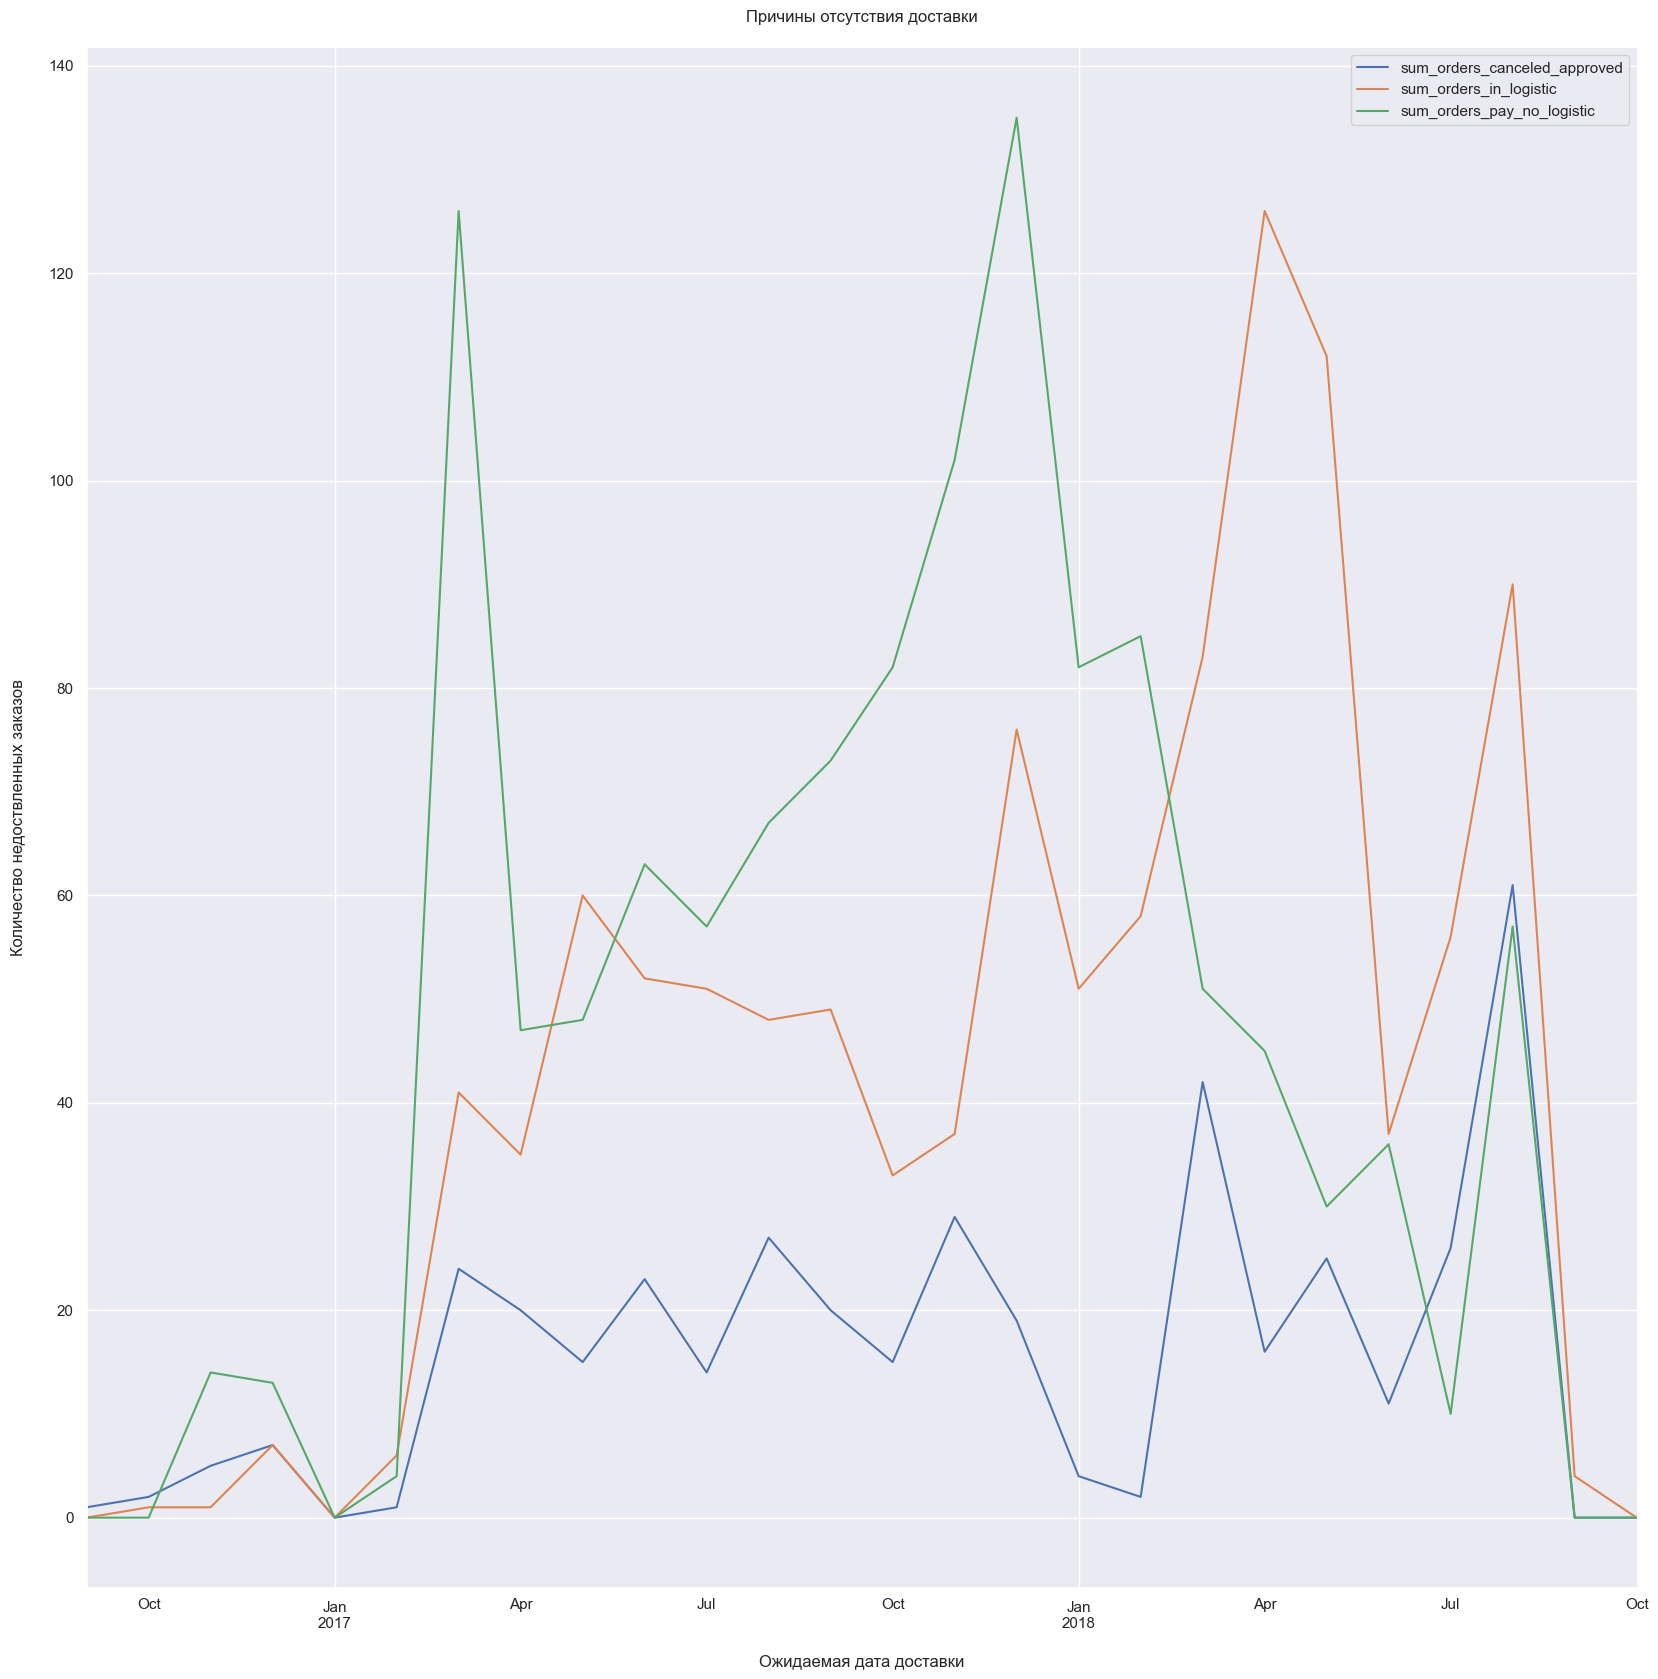

In [28]:
#Построим график зависимости коичества недоставленных заказов от обещанной даты доставки
a = orders_no_delivered_by_reason.drop(columns = ['sum_orders', 'orders_in_logistic', 'orders_canceled_approved', 'orders_pay_no_logistic'])
a = a.set_index('order_estimated_delivery_date')
ax = a.plot()
ax.set_title('Причины отсутствия доставки\n') #название графика с пропуском строки
ax.set_xlabel('\nОжидаемая дата доставки') #газвание осей
ax.set_ylabel('Количество недоствленных заказов\n')
sns.set(rc = {'figure.figsize':(20,20)})

sns.despine()

In [29]:
#Выведем общую таблицу
orders_no_delivered_by_reason

,order_estimated_delivery_date,sum_orders_canceled_approved,sum_orders_in_logistic,sum_orders_pay_no_logistic,sum_orders,orders_canceled_approved,orders_in_logistic,orders_pay_no_logistic
0,2016-09-30,1.0,0.0,0.0,1,100.000000,0.000000,0.000000
1,2016-10-31,2.0,1.0,0.0,5,40.000000,20.000000,0.000000
2,2016-11-30,5.0,1.0,14.0,166,3.012048,0.602410,8.433735
3,2016-12-31,7.0,7.0,13.0,148,4.729730,4.729730,8.783784
4,2017-01-31,0.0,0.0,0.0,3,0.000000,0.000000,0.000000
5,2017-02-28,1.0,6.0,4.0,315,0.317460,1.904762,1.269841
6,2017-03-31,24.0,41.0,126.0,2785,0.861759,1.472172,4.524237
7,2017-04-30,20.0,35.0,47.0,2233,0.895656,1.567398,2.104792
8,2017-05-31,15.0,60.0,48.0,3029,0.495213,1.980852,1.584681
9,2017-06-30,23.0,52.0,63.0,3633,0.633086,1.431324,1.734104


In [30]:
#Также рассчитаем средне кол-во недоставленных заказов
orders_no_delivered_by_reason.drop('order_estimated_delivery_date', axis = 1).mean()

sum_orders_canceled_approved      15.730769
sum_orders_in_logistic            42.846154
sum_orders_pay_no_logistic        47.192308
sum_orders                      3818.500000
orders_canceled_approved           6.002079
orders_in_logistic                 1.878036
orders_pay_no_logistic             1.741856
dtype: float64

In [31]:
#Был построен график зависимотси количества недоставленных заказов по месяцам от месяца ожидаемой доставки,
#по которому видно на первом графике(процентном) высокое значение в начале графика, которое может быть 
#обосновано тем, что мы знаем количество заказов только на конец месяц, а не за весь месяц, были также скачки с октября 2016
#по январь 2017, также причина может быть в том, что компания только начала заниматься доставкой и не все сегменты доставки 
#были налажены, либо компания только создавалась и это мог быть тестовый заказ.
#Если мы посмотрим на второй график, то создается впечатление, что много недоставленных заказов по возможной причине 
#потери товара в пути или отсутствия товара на складе. Но если оценивать количество недоставленных заказов относительно
#общего числа заказов в этом месяце в процентном соотношении то судя по первому графику процент недоставленных заказов, 
#начиная с января 2017 года составлял не более 5%. До января 2017 года возможно фирма налаживала логистику в течении нескольких
#месяцев или только недавно открылась.
#Причины, которым заказы не доставлялись следуюющие:
#потеря товара в пути
#покупатель не подтвердил факт получения товара, хотя товар доставлен
#отсутстсвие товара на складе
#проблемы у продавца с логистической фирмой
#отказ покупателя

### 3 По каждому товару определить, в какой день недели товар чаще всего покупается (день покупки-день оплаты заказа, так как именно тогда деньги поступили на счет продавца)

In [32]:
orders_day_items=all_orders
orders_day_items['day_of_week_order']=orders_day_items['order_approved_at'].dt.strftime('%A')
orders_day_items

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week_order
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,Thursday
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22,Wednesday
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112630,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,1,f1d4ce8c6dd66c47bbaa8c6781c2a923,1f9ab4708f3056ede07124aad39a2554,2018-02-12 13:10:37,174.90,20.10,Tuesday
112631,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,1,b80910977a37536adeddd63663f916ad,d50d79cb34e38265a8649c383dcffd48,2017-09-05 15:04:16,205.99,65.02,Sunday
112632,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,1,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday
112633,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2,d1c427060a0f73f6b889a5c7c61f2ac4,a1043bafd471dff536d0c462352beb48,2018-01-12 21:36:21,179.99,40.59,Monday


In [33]:
orders_items_count=orders_day_items.groupby(['product_id', 'day_of_week_order'], as_index=False)\
    .agg({'customer_id':'count'})\
    .rename(columns = {'customer_id':'count_product'})
orders_items_count

,product_id,day_of_week_order,count_product
0,00066f42aeeb9f3007548bb9d3f33c38,Sunday,1
1,00088930e925c41fd95ebfe695fd2655,Tuesday,1
2,0009406fd7479715e4bef61dd91f2462,Friday,1
3,000b8f95fcb9e0096488278317764d19,Friday,1
4,000b8f95fcb9e0096488278317764d19,Wednesday,1
...,...,...,...
61138,fff9553ac224cec9d15d49f5a263411f,Saturday,1
61139,fffdb2d0ec8d6a61f0a0a0db3f25b441,Friday,1
61140,fffdb2d0ec8d6a61f0a0a0db3f25b441,Thursday,1
61141,fffdb2d0ec8d6a61f0a0a0db3f25b441,Tuesday,3


In [34]:
orders_items_count=orders_items_count.pivot(index='product_id', columns='day_of_week_order', values='count_product').reset_index().fillna(0)
orders_items_count

day_of_week_order,product_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0009406fd7479715e4bef61dd91f2462,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
32943,fff6177642830a9a94a0f2cba5e476d1,0.0,1.0,1.0,0.0,0.0,0.0,0.0
32944,fff81cc3158d2725c0655ab9ba0f712c,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32945,fff9553ac224cec9d15d49f5a263411f,0.0,0.0,1.0,0.0,0.0,0.0,0.0
32946,fffdb2d0ec8d6a61f0a0a0db3f25b441,1.0,0.0,0.0,0.0,1.0,3.0,0.0


In [35]:
v = orders_items_count.eq(orders_items_count.max(axis=1), axis=0).dot(orders_items_count.columns + ',').str.rstrip(',')
orders_items_count['popular_day_for_product_order'] = v.mask(orders_items_count.eq(0).all(axis=1))

C:\Users\anna1\AppData\Local\Temp\ipykernel_19168\394661660.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  v = orders_items_count.eq(orders_items_count.max(axis=1), axis=0).dot(orders_items_count.columns + ',').str.rstrip(',')


In [36]:
orders_items_count

day_of_week_order,product_id,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,popular_day_for_product_order
0,00066f42aeeb9f3007548bb9d3f33c38,0.0,0.0,0.0,1.0,0.0,0.0,0.0,Sunday
1,00088930e925c41fd95ebfe695fd2655,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Tuesday
2,0009406fd7479715e4bef61dd91f2462,1.0,0.0,0.0,0.0,0.0,0.0,0.0,Friday
3,000b8f95fcb9e0096488278317764d19,1.0,0.0,0.0,0.0,0.0,0.0,1.0,"Friday,Wednesday"
4,000d9be29b5207b54e86aa1b1ac54872,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Tuesday
...,...,...,...,...,...,...,...,...,...
32943,fff6177642830a9a94a0f2cba5e476d1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,"Monday,Saturday"
32944,fff81cc3158d2725c0655ab9ba0f712c,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Monday
32945,fff9553ac224cec9d15d49f5a263411f,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Saturday
32946,fffdb2d0ec8d6a61f0a0a0db3f25b441,1.0,0.0,0.0,0.0,1.0,3.0,0.0,Tuesday


In [37]:
#Если на неделе было несколько дней с равным количеством заказов одного продукта, то выведено несколько дней недели,
# так как дни недели равнозначны и невозможно выбрать один день, пренебрегая другим

### 4 Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть

In [38]:
#(день покупки-день оплаты заказа, так как именно тогда деньги поступили на счет продавца)

In [39]:
#Конвертация времени оплаты заказа
orders_date = orders_buy.merge( customers, how = 'inner', on = 'customer_id' )
orders_date['order_purchase_date'] = orders_date['order_approved_at'].dt.date
orders_date

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017-10-02
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018-07-26
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018-08-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017-11-18
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018-02-13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99276,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,2017-03-09
99277,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP,2018-02-06
99278,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA,2017-08-27
99279,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ,2018-01-08


In [40]:
#Расчет среднего числа покупок по неделям.
#Группируем по уникальному номеру пользователя и дню оплаты зазказа и считаем кол-во заказов

orders_group_date=orders_date.groupby(['order_purchase_date', 'customer_unique_id'], as_index=False).agg({'order_id':'nunique'})\
    .rename(columns={'order_id':'count_orders'})

In [41]:
# Преобразуем  колонку order_purchase_date в тип datetime
orders_group_date['order_purchase_date'] = pd.to_datetime(orders_group_date['order_purchase_date'])


In [42]:
#Вычленяем месяц из дня оплаты заказа

orders_group_date['month'] = orders_group_date.order_purchase_date.dt.to_period('M')

In [43]:
# Счтитаем количество заказов в месяц для каждого пользователя

orders_mean = orders_group_date.groupby(['customer_unique_id', 'month'], as_index = False)\
    .agg({'count_orders':'sum'}).rename(columns = {'count_orders':'sum_orders'})

In [44]:
#Считаем кол-во недель в каждом месяце с учетом года

orders_mean['sum_weeks'] = orders_mean.month.dt.daysinmonth/7

In [45]:
#Таким образом, находим среднего кол-во покупок по неделям

orders_mean['mean_by_week'] = orders_mean.sum_orders / orders_mean.sum_weeks

In [46]:
orders_mean

,customer_unique_id,month,sum_orders,sum_weeks,mean_by_week
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.225806
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714,0.233333
...,...,...,...,...,...
97907,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1,4.285714,0.233333
97908,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1,4.428571,0.225806
97909,ffff371b4d645b6ecea244b27531430a,2017-02,1,4.000000,0.250000
97910,ffff5962728ec6157033ef9805bacc48,2018-05,1,4.428571,0.225806


In [47]:
#Расчет среднего числа покупок по месяцам
orders_mean['mean by month'] = orders_mean.sum_orders / orders_mean.month.nunique()

In [48]:
orders_mean

,customer_unique_id,month,sum_orders,sum_weeks,mean_by_week,mean by month
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05,1,4.428571,0.225806,0.041667
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05,1,4.428571,0.225806,0.041667
2,0000f46a3911fa3c0805444483337064,2017-03,1,4.428571,0.225806,0.041667
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10,1,4.428571,0.225806,0.041667
4,0004aac84e0df4da2b147fca70cf8255,2017-11,1,4.285714,0.233333,0.041667
...,...,...,...,...,...,...
97907,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06,1,4.285714,0.233333,0.041667
97908,fffea47cd6d3cc0a88bd621562a9d061,2017-12,1,4.428571,0.225806,0.041667
97909,ffff371b4d645b6ecea244b27531430a,2017-02,1,4.000000,0.250000,0.041667
97910,ffff5962728ec6157033ef9805bacc48,2018-05,1,4.428571,0.225806,0.041667


### 5 Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

In [49]:
#Так как у нас полный год только 2017, то будем проводить когортный анализ в этот год

In [50]:
customer_id_  = all_orders

In [51]:
#Конвертация времени оплаты заказа
customer_id_['order_purchase_date'] = customer_id_['order_approved_at'].dt.date
customer_id_['order_purchase_date'] = pd.to_datetime(customer_id_['order_purchase_date'])
customer_id_ = customer_id_.query("order_purchase_date >= '2017-01-01' and order_purchase_date <= '2017-12-31'")
customer_id_

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,day_of_week_order,order_purchase_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,Monday,2017-10-02
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20,Saturday,2017-11-18
5,a4591c265e18cb1dcee52889e2d8acc3,503740e9ca751ccdda7ba28e9ab8f608,delivered,2017-07-09 21:57:05,2017-07-09 22:10:13,2017-07-11 14:58:04,2017-07-26 10:57:55,2017-08-01,80bb27c7c16e8f973207a5086ab329e2,86320,congonhinhas,PR,1,060cb19345d90064d1015407193c233d,8581055ce74af1daba164fdbd55a40de,2017-07-13 22:10:13,147.90,27.36,Sunday,2017-07-09
6,136cce7faa42fdb2cefd53fdc79a6098,ed0271e0b7da060a393796590e7b737a,invoiced,2017-04-11 12:22:08,2017-04-13 13:25:17,NaT,NaT,2017-05-09,36edbb3fb164b1f16485364b6fb04c73,98900,santa rosa,RS,1,a1804276d9941ac0733cfd409f5206eb,dc8798cbf453b7e0f98745e396cc5616,2017-04-19 13:25:17,49.90,16.05,Thursday,2017-04-13
7,6514b8ad8028c9f2cc2374ded245783f,9bdf08b4b3b52b5526ff42d37d47f222,delivered,2017-05-16 13:10:30,2017-05-16 13:22:11,2017-05-22 10:07:46,2017-05-26 12:55:51,2017-06-07,932afa1e708222e5821dac9cd5db4cae,26525,nilopolis,RJ,1,4520766ec412348b8d4caa5e8a18c464,16090f2ca825584b5a147ab24aa30c86,2017-05-22 13:22:11,59.99,15.17,Tuesday,2017-05-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112626,9115830be804184b91f5c00f6f49f92d,da2124f134f5dfbce9d06f29bdb6c308,delivered,2017-10-04 19:57:37,2017-10-04 20:07:14,2017-10-05 16:52:52,2017-10-20 20:25:45,2017-11-07,c716cf2b5b86fb24257cffe9e7969df8,78048,cuiaba,MT,2,49d2e2460386273b195e7e59b43587c3,1caf283236cd69af44cbc09a0a1e7d32,2017-10-10 20:07:14,26.90,36.98,Wednesday,2017-10-04
112627,aa04ef5214580b06b10e2a378300db44,f01a6bfcc730456317e4081fe0c9940e,delivered,2017-01-27 00:30:03,2017-01-27 01:05:25,2017-01-30 11:40:16,2017-02-07 13:15:25,2017-03-17,e03dbdf5e56c96b106d8115ac336f47f,35502,divinopolis,MG,1,9fc063fd34fed29ccc57b7f8e8d03388,ccc4bbb5f32a6ab2b7066a4130f114e3,2017-02-03 00:30:03,370.00,19.43,Friday,2017-01-27
112628,880675dff2150932f1601e1c07eadeeb,47cd45a6ac7b9fb16537df2ccffeb5ac,delivered,2017-02-23 09:05:12,2017-02-23 09:15:11,2017-03-01 10:22:52,2017-03-06 11:08:08,2017-03-22,831ce3f1bacbd424fc4e38fbd4d66d29,5127,sao paulo,SP,1,ea73128566d1b082e5101ce46f8107c7,391fc6631aebcf3004804e51b40bcf1e,2017-02-27 09:05:12,139.90,16.09,Thursday,2017-02-23
112629,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP,1,ac35486adb7b02598c182c2ff2e05254,e24fc9fcd865784fb25705606fe3dfe7,2017-03-15 09:54:05,72.00,13.08,Thursday,2017-03-09


In [52]:
customer_id_delivery = customer_id_.groupby(['customer_unique_id', 'order_purchase_date'], as_index = False )\
                            .agg( {'order_id':'count'} )
customer_id_delivery

,customer_unique_id,order_purchase_date,order_id
0,0000f46a3911fa3c0805444483337064,2017-03-10,1
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,1
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14,1
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-04,1
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18,1
...,...,...,...
43962,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-27,1
43963,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,2
43964,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,1
43965,ffff371b4d645b6ecea244b27531430a,2017-02-07,1


In [53]:
#Коныертация даты заказа в месяц и определенной первого месяца заказа
customer_id_delivery['month'] = customer_id_delivery['order_purchase_date'].dt.to_period('M')

customer_id_delivery['cohort'] = customer_id_delivery.groupby('customer_unique_id')\
    .order_purchase_date.transform('min') \
    .dt.to_period('M')
customer_id_delivery

,customer_unique_id,order_purchase_date,order_id,month,cohort
0,0000f46a3911fa3c0805444483337064,2017-03-10,1,2017-03,2017-03
1,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12,1,2017-10,2017-10
2,0004aac84e0df4da2b147fca70cf8255,2017-11-14,1,2017-11,2017-11
3,0005e1862207bf6ccc02e4228effd9a0,2017-03-04,1,2017-03,2017-03
4,0006fdc98a402fceb4eb0ee528f6a8d4,2017-07-18,1,2017-07,2017-07
...,...,...,...,...,...
43962,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-27,1,2017-12,2017-12
43963,fffcf5a5ff07b0908bd4e2dbc735a684,2017-06-08,2,2017-06,2017-06
43964,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10,1,2017-12,2017-12
43965,ffff371b4d645b6ecea244b27531430a,2017-02-07,1,2017-02,2017-02


In [54]:
#Группировка по месяцу заказа и месяцу первого заказа, разница мужду месяцем заказа и месяцем первого заказа
cohort_df = customer_id_delivery.groupby(['cohort', 'month'], as_index=False) \
 .agg(user_count=('customer_unique_id', 'nunique'))
cohort_df['period_number'] = (cohort_df.month - cohort_df.cohort) \
 .apply(attrgetter('n'))
cohort_df

,cohort,month,user_count,period_number
0,2017-01,2017-01,719,0
1,2017-01,2017-02,4,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
...,...,...,...,...
72,2017-10,2017-11,30,1
73,2017-10,2017-12,13,2
74,2017-11,2017-11,7082,0
75,2017-11,2017-12,39,1


In [55]:
cohort_pivot = cohort_df.pivot_table(index='cohort', columns='period_number', values='user_count')
cohort_pivot

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,719.0,4.0,2.0,1.0,3.0,1.0,3.0,1.0,1.0,NaN,2.0,2.0
2017-02,1689.0,4.0,4.0,3.0,7.0,2.0,4.0,3.0,1.0,3.0,2.0,NaN
2017-03,2604.0,13.0,9.0,9.0,9.0,4.0,4.0,8.0,8.0,3.0,NaN,NaN
2017-04,2315.0,14.0,5.0,4.0,7.0,6.0,8.0,6.0,8.0,NaN,NaN,NaN
2017-05,3561.0,19.0,17.0,14.0,11.0,12.0,15.0,5.0,NaN,NaN,NaN,NaN
2017-06,3124.0,15.0,11.0,12.0,8.0,11.0,12.0,NaN,NaN,NaN,NaN,NaN
2017-07,3798.0,20.0,13.0,7.0,13.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,4173.0,28.0,15.0,11.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,4113.0,27.0,20.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

In [57]:
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-01,1.0,0.005563,0.002782,0.001391,0.004172,0.001391,0.004172,0.001391,0.001391,NaN,0.002782,0.002782
2017-02,1.0,0.002368,0.002368,0.001776,0.004144,0.001184,0.002368,0.001776,0.000592,0.001776,0.001184,NaN
2017-03,1.0,0.004992,0.003456,0.003456,0.003456,0.001536,0.001536,0.003072,0.003072,0.001152,NaN,NaN
2017-04,1.0,0.006048,0.002160,0.001728,0.003024,0.002592,0.003456,0.002592,0.003456,NaN,NaN,NaN
2017-05,1.0,0.005336,0.004774,0.003931,0.003089,0.003370,0.004212,0.001404,NaN,NaN,NaN,NaN
2017-06,1.0,0.004802,0.003521,0.003841,0.002561,0.003521,0.003841,NaN,NaN,NaN,NaN,NaN
2017-07,1.0,0.005266,0.003423,0.001843,0.003423,0.001843,NaN,NaN,NaN,NaN,NaN,NaN
2017-08,1.0,0.006710,0.003595,0.002636,0.003834,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-09,1.0,0.006565,0.004863,0.003404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
#когорта с самым высоким retention за третий месяц 2017-05

### 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. 

В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. 


In [59]:
#Для расчета recency объединим orders_buy и customers
orders_customer = orders_buy.merge( customers, how = 'inner', on = 'customer_id' )
orders_customer

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP
...,...,...,...,...,...,...,...,...,...,...,...,...
99276,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,6359f309b166b0196dbf7ad2ac62bb5a,12209,sao jose dos campos,SP
99277,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,da62f9e57a76d978d02ab5362c509660,11722,praia grande,SP
99278,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,737520a9aad80b3fbbdad19b66b37b30,45920,nova vicosa,BA
99279,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,5097a5312c8b157bb7be58ae360ef43c,28685,japuiba,RJ


In [60]:
#Объединяем по покупателю с указанием последнего дня покупки пользователя и посчитаем время от последнего дня покупки 
#до последнего дня покупки за весь иследуемый период, так нет данных за часть 2018 года и остальное время до настоящего дня  
#и округлим до дней, таким образом посчитаем Recency
last_bought = orders_customer.groupby(['customer_unique_id'], as_index = False).agg({'order_approved_at':'max'})
last_bought['Recency'] = ((last_bought.order_approved_at.max()-last_bought.order_approved_at) / np.timedelta64(1, 'D')).astype(int)
last_bought = last_bought.drop(columns = ['order_approved_at'])
last_bought

,customer_unique_id,Recency
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118
2,0000f46a3911fa3c0805444483337064,541
3,0000f6ccb0745a6a4b88665a16c9f078,325
4,0004aac84e0df4da2b147fca70cf8255,292
...,...,...
95992,fffcf5a5ff07b0908bd4e2dbc735a684,451
95993,fffea47cd6d3cc0a88bd621562a9d061,266
95994,ffff371b4d645b6ecea244b27531430a,573
95995,ffff5962728ec6157033ef9805bacc48,124


In [61]:
#Расчитаем кол-во покупок для каждого пользователя за указанный период, то есть Frequency 
count_bought = orders_customer.groupby(['customer_unique_id'], as_index = False)\
    .agg({'order_id':'nunique'})\
    .rename(columns = {'order_id':'Frequency'})
count_bought

,customer_unique_id,Frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95992,fffcf5a5ff07b0908bd4e2dbc735a684,1
95993,fffea47cd6d3cc0a88bd621562a9d061,1
95994,ffff371b4d645b6ecea244b27531430a,1
95995,ffff5962728ec6157033ef9805bacc48,1


In [62]:
#Расчитаем сумму покупок дл каждого покупателя, то есть Monetary (используем ранее смердженную таблицу)

sum_for_customers = all_orders.groupby(['customer_unique_id'], as_index = False)\
    .agg({'price':'sum'})\
    .rename(columns = {'price':'Monetary'})
sum_for_customers

,customer_unique_id,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00
...,...,...
95402,fffcf5a5ff07b0908bd4e2dbc735a684,1570.00
95403,fffea47cd6d3cc0a88bd621562a9d061,64.89
95404,ffff371b4d645b6ecea244b27531430a,89.90
95405,ffff5962728ec6157033ef9805bacc48,115.00


In [63]:
#Объединим таблицы по customer_id
rfm = pd.merge(last_bought, count_bought, how = 'inner', on = 'customer_unique_id')
rfm = rfm.merge(sum_for_customers, how = 'inner', on = 'customer_unique_id')
rfm

,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90
2,0000f46a3911fa3c0805444483337064,541,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00
...,...,...,...,...
95402,fffcf5a5ff07b0908bd4e2dbc735a684,451,1,1570.00
95403,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89
95404,ffff371b4d645b6ecea244b27531430a,573,1,89.90
95405,ffff5962728ec6157033ef9805bacc48,124,1,115.00


In [64]:
#Для начала рассмотрим графики распределний RFM и посмотрим их описание

In [65]:
rfm.Recency.describe()

count    95407.000000
mean       242.623822
std        153.113378
min          0.000000
25%        118.000000
50%        223.000000
75%        352.000000
max        718.000000
Name: Recency, dtype: float64

In [66]:
rfm.Recency.median()

223.0

<AxesSubplot: ylabel='Recency'>

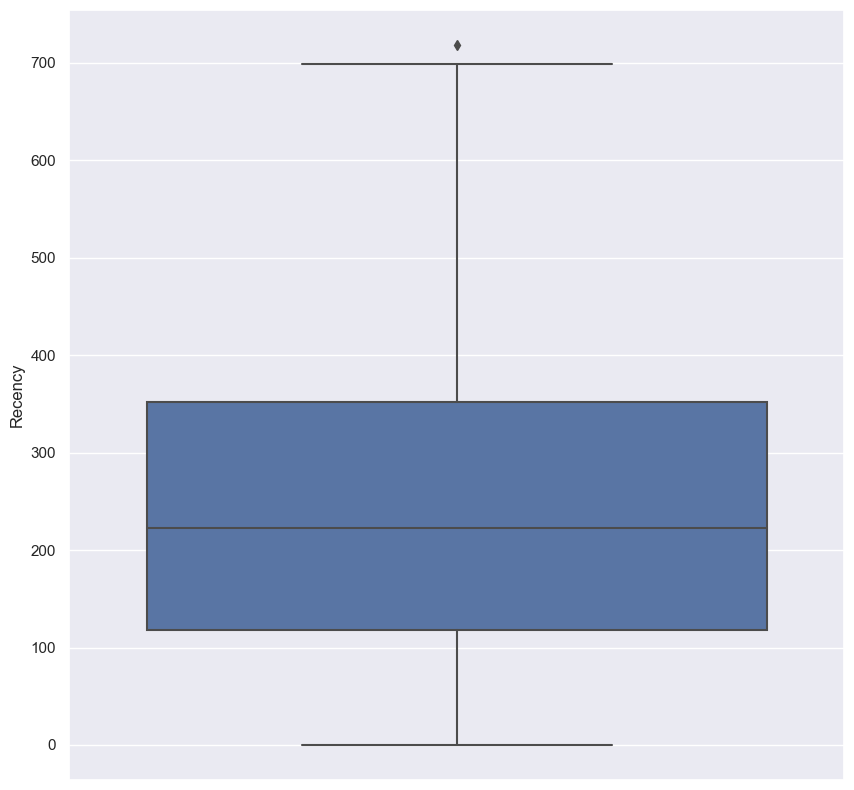

In [67]:
#График боксплот покажет, как распределена основная разница в днях и как распределена часть, которая не входит в IQR.
# Около 75% данных распределены в пределах значения 355, поэтому разделим этот промежуток на три участка и оставшийся участок все,
#что больше 0.75 квантиля.
plt.figure(figsize=(10,10))
sns.boxplot(y = rfm.Recency)

In [68]:
#только округлим до целых, кратных десяти
quintiles_r = rfm[['Recency']].quantile([.25, 0.5, 0.75])
quintiles_r = quintiles_r.round(-1)
quintiles_r

,Recency
0.25,120.0
0.50,220.0
0.75,350.0


C:\Users\anna1\AppData\Local\Temp\ipykernel_19168\1715164515.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['Recency'], kde = False)


<AxesSubplot: xlabel='Recency'>

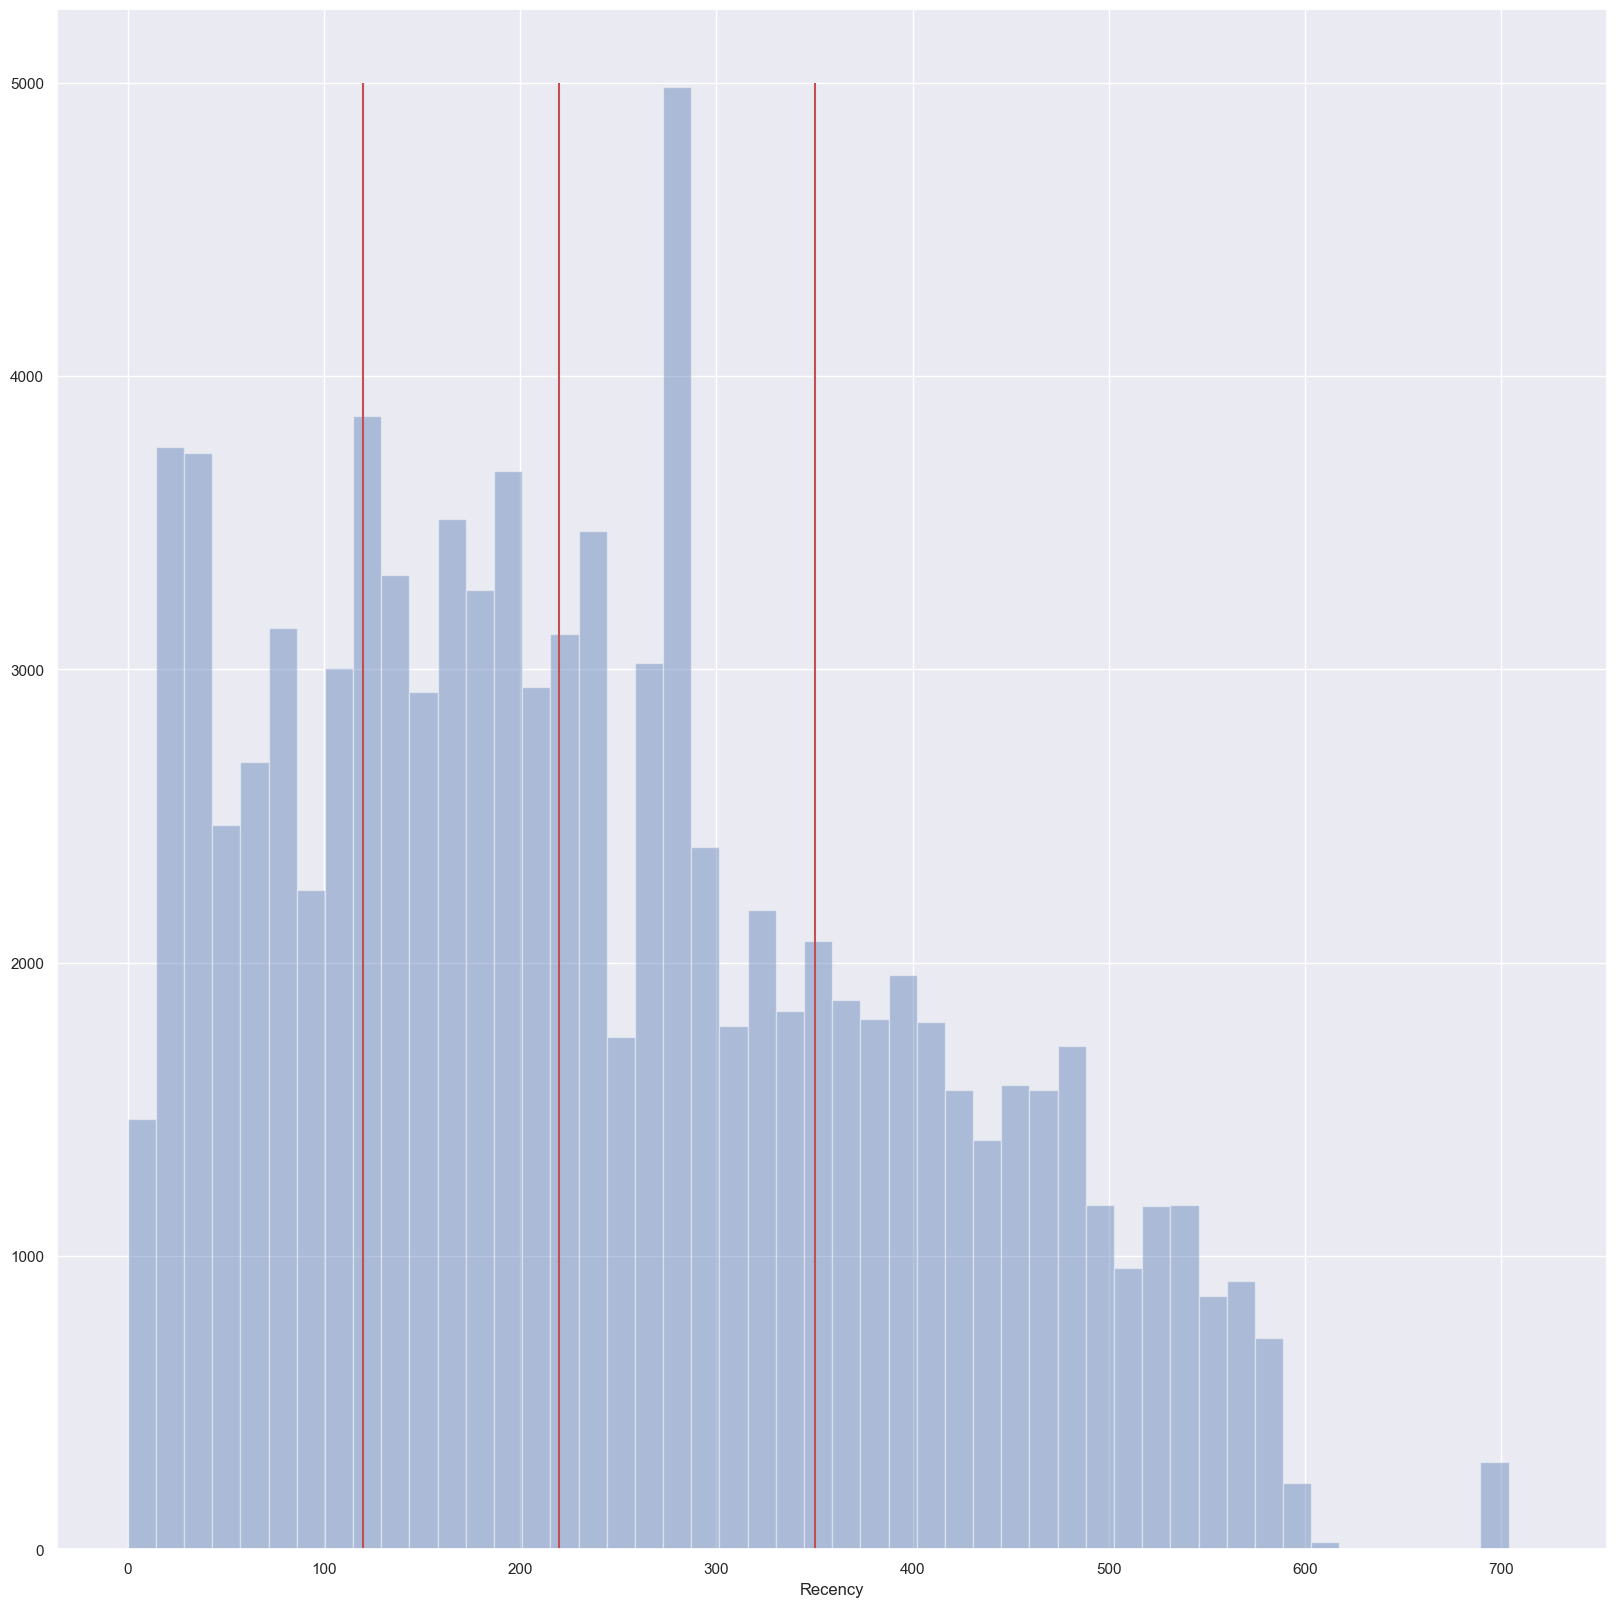

In [69]:
#Построим график с сегментацией
ymin = 0
ymax = 5000
x1 = round(rfm[['Recency']].quantile([.25]), -1)
x2 = round(rfm[['Recency']].quantile([.5]), -1)
x3 = round(rfm[['Recency']].quantile([.75]), -1)
fig, ax = plt.subplots()
ax.vlines(x1, ymin, ymax, color = 'r')
ax.vlines(x2, ymin, ymax, color = 'r')
ax.vlines(x3, ymin, ymax, color = 'r')
sns.distplot(rfm['Recency'], kde = False)

In [70]:
#Присвоение рангов в соответствии с сегментацие, где 1 - это пользователи, которые сделали заказ недавно и 4, которые 
#давно ничего не заказывали
def r_score(x):
    if x <= quintiles_r.Recency[0.25]:
        return 4
    elif x <= quintiles_r.Recency[0.5]:
        return 3
    elif x <= quintiles_r.Recency[0.75]:
        return 2
    else:
        return 1
    
rfm['R'] = rfm.Recency.apply(lambda x: r_score(x))

In [71]:
#Основная часть пользователей совершили только одну покупку (около 87,5%), около 9% совершили 2 покупки и оставшаяся часть 
#(менее 5 %) более 2 покупок
#Поэтому логично так и разделить пользователей по сегментам: одна покупка, две покупки и более двух покупок

In [72]:
rfm.query('Frequency==1')

,customer_unique_id,Recency,Frequency,Monetary,R
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,2
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,2
...,...,...,...,...,...
95402,fffcf5a5ff07b0908bd4e2dbc735a684,451,1,1570.00,1
95403,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89,2
95404,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1
95405,ffff5962728ec6157033ef9805bacc48,124,1,115.00,3


In [73]:
rfm.query('Frequency==2')

,customer_unique_id,Recency,Frequency,Monetary,R
106,004288347e5e88a27ded2bb23747066c,232,2,317.89,2
123,004b45ec5c64187465168251cd1c9c2f,97,2,86.90,4
143,0058f300f57d7b93c477a131a59b36c3,164,2,132.48,3
246,00a39521eb40f7012db50455bf083460,92,2,81.45,4
309,00cc12a6d8b578b8ebd21ea4e2ae8b27,530,2,99.80,1
...,...,...,...,...,...
95023,ff03923ad1eb9e32304deb7f9b2a45c9,98,2,220.64,4
95070,ff22e30958c13ffe219db7d711e8f564,0,2,290.00,4
95122,ff44401d0d8f5b9c54a47374eb48c1b8,471,2,39.80,1
95228,ff8892f7c26aa0446da53d01b18df463,280,2,277.95,2


In [74]:
rfm.query('Frequency>2')

,customer_unique_id,Recency,Frequency,Monetary,R
1085,02e9109b7e0a985108b43e573b6afb23,111,3,532.87,4
1526,041caba6a63ace5818387698ea85cdb2,102,3,121.89,4
2474,06a52782a04f0086d16b9c22d0e29438,484,3,105.00,1
2885,07b1b60bca2b6326fa2adb259ea4a55f,117,3,190.40,4
3106,083ca1aa470c280236380973a48f77c6,20,4,218.88,4
...,...,...,...,...,...
94068,fc719c11b4dce594f47e1f9aa739a3a2,250,3,220.99,2
94477,fd8ccc89be43894d2553494c71a61fd8,137,3,179.44,3
94779,fe59d5878cd80080edbd29b5a0a4e1cf,376,3,127.78,1
94850,fe81bb32c243a86b2f86fbf053fe6140,74,5,1535.40,4


C:\Users\anna1\AppData\Local\Temp\ipykernel_19168\177053976.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm['Frequency'], kde = False)


<AxesSubplot: xlabel='Frequency'>

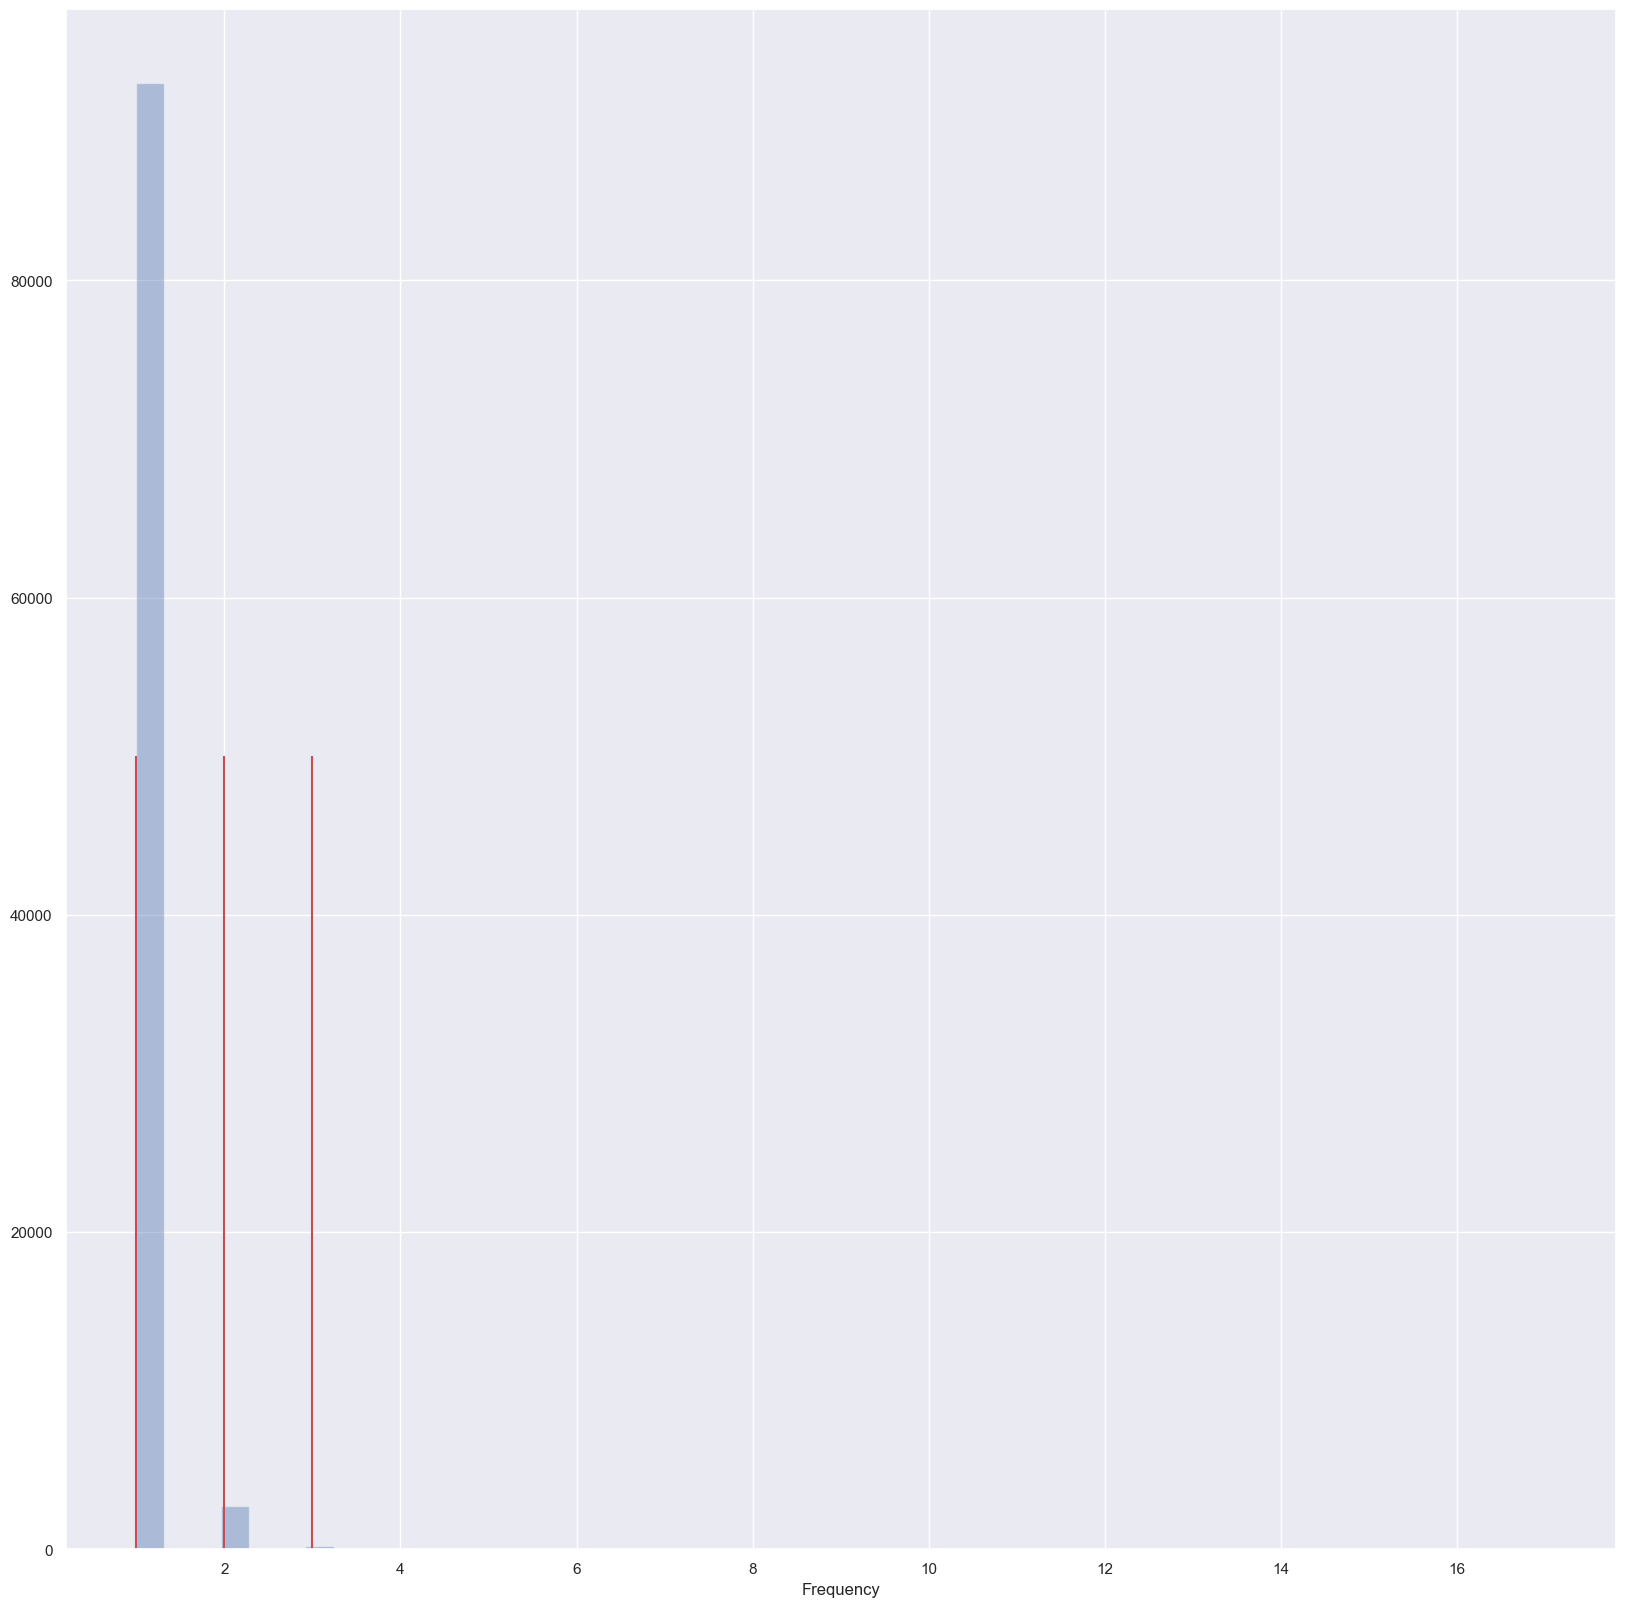

In [75]:
#Построим график с сегментацией
ymin = 0
ymax = 50000
x1 = 1
x2 = 2
x3 = 3
fig, ax = plt.subplots()
ax.vlines(x1, ymin, ymax, color = 'r')
ax.vlines(x2, ymin, ymax, color = 'r')
ax.vlines(x3, ymin, ymax, color = 'r')
sns.distplot(rfm['Frequency'], kde = False)

In [76]:
#Присвоение рангов в соответствии с сегментацие, где 1 - это пользователи, которые сделали заказ недавно и 4, которые 
#давно ничего не заказывали
def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    else:
        return 3
    
rfm['F'] = rfm['Frequency'].apply(lambda x: f_score(x))

C:\Users\anna1\AppData\Local\Temp\ipykernel_19168\383012336.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm.Monetary, kde = False)


<AxesSubplot: xlabel='Monetary'>

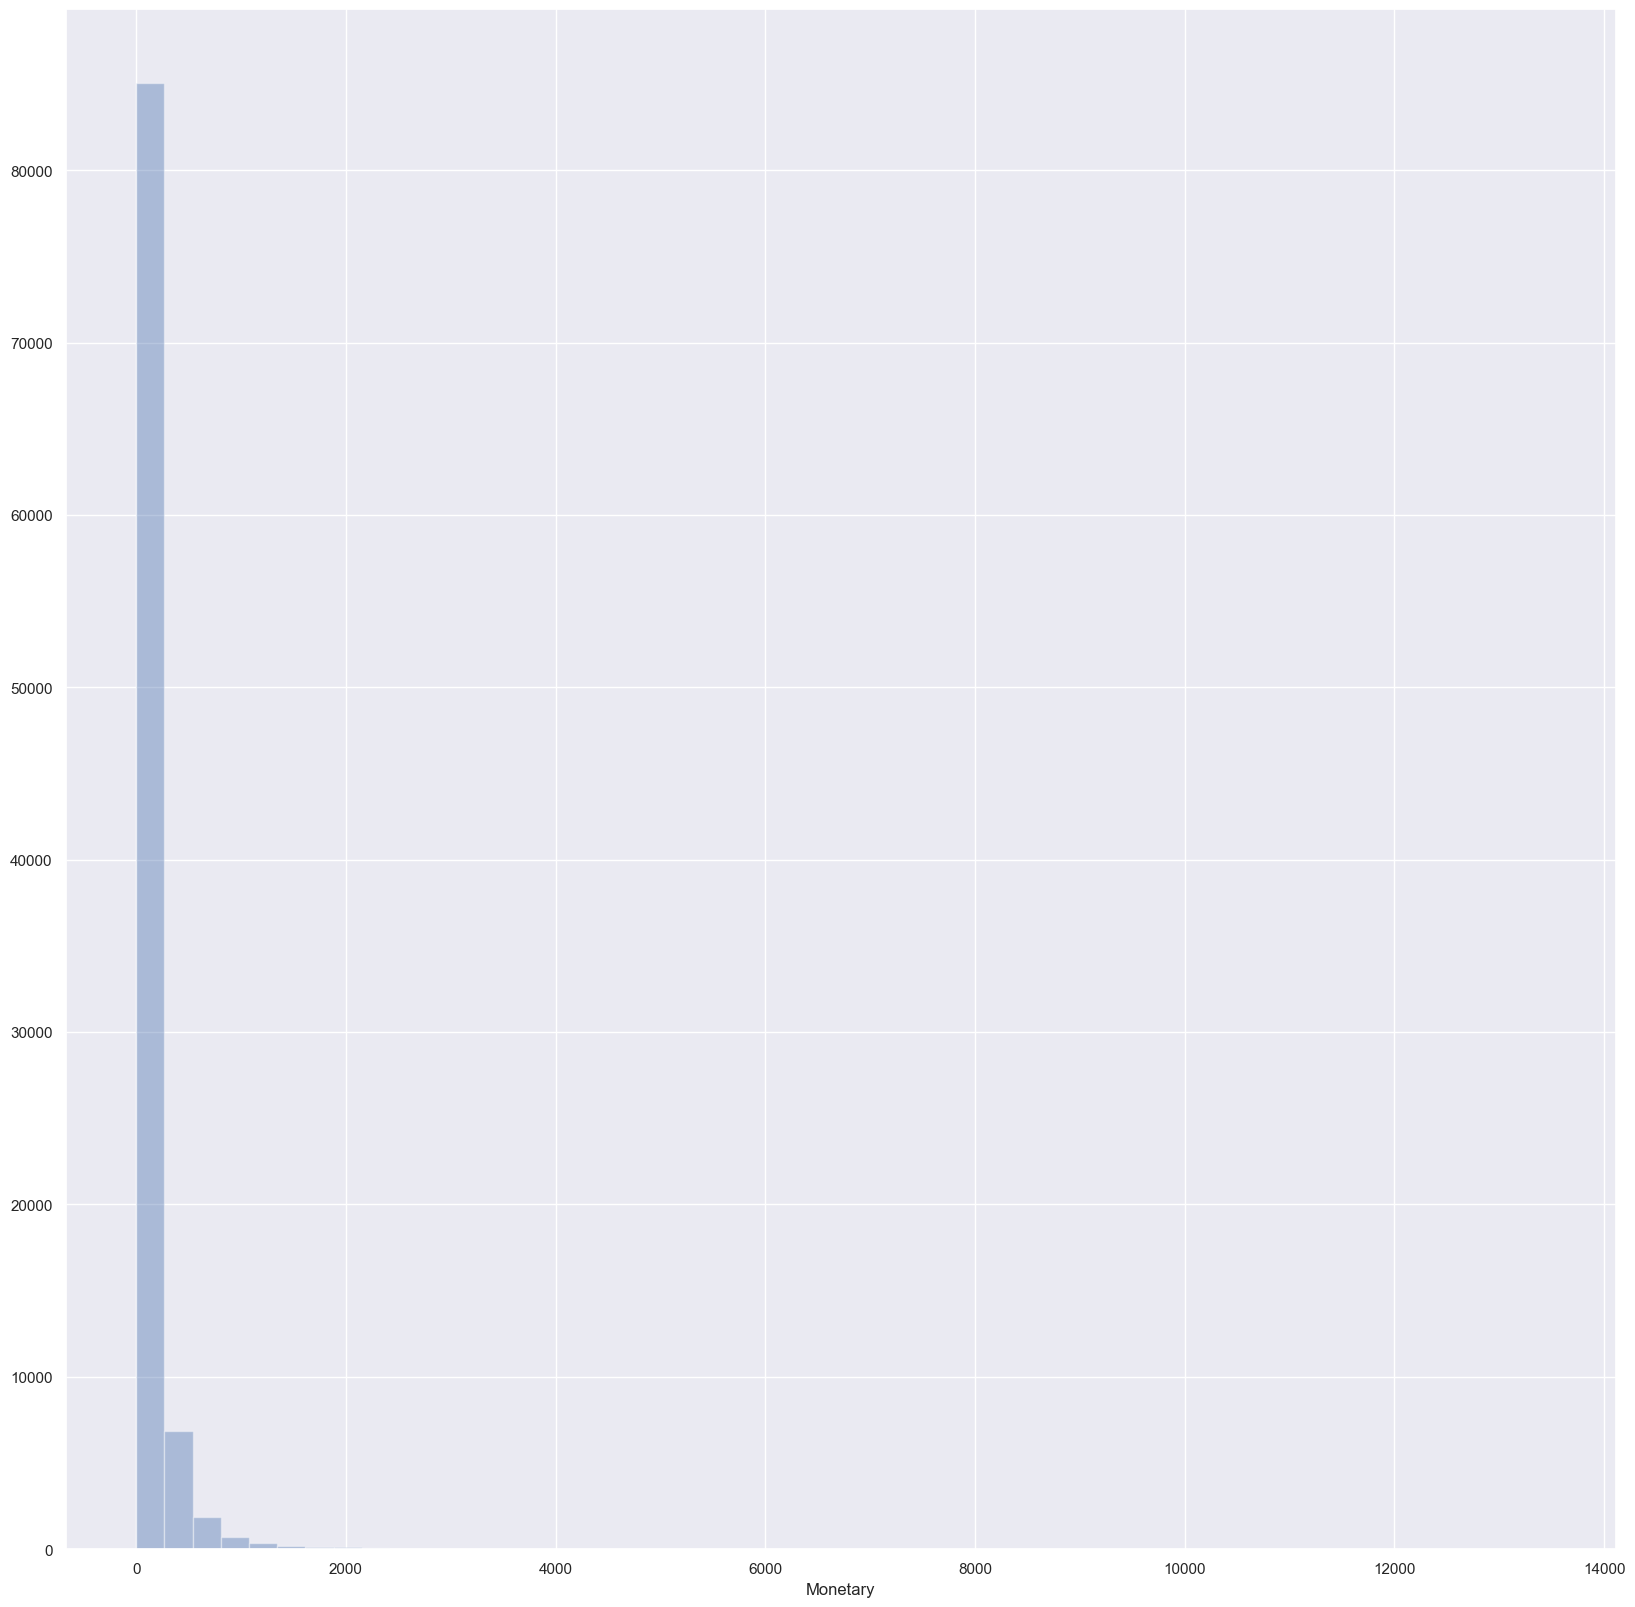

In [77]:
sns.distplot(rfm.Monetary, kde = False)

In [78]:
#По квантилям посмотрим, где сосредоточены 75 процентов наблюдеий и для началавыделим такие сегменты
quintile_m = rfm[['Monetary']].quantile([.25, 0.5, 0.75])
quintile_m = quintile_m.round(-1)
quintile_m

,Monetary
0.25,50.0
0.50,90.0
0.75,160.0


In [79]:
rfm.Monetary.describe()

count    95407.000000
mean       142.442098
std        217.667272
min          0.850000
25%         47.900000
50%         89.900000
75%        155.000000
max      13440.000000
Name: Monetary, dtype: float64

In [80]:
#Около 50% значений находятся в пределах IQR, 25 % это значения ниже 0,25 квантиля.
#Часть значений разобьем по квантилям, указанным выше, далее рассмотри большие начения превосходящие 0.75 квантиль
#Рассмотрим значения >155, по графиу видно, что большая часть значений приходится до 2000, приблизим график, поставив доп. ограничения

C:\Users\anna1\AppData\Local\Temp\ipykernel_19168\3173752888.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_max.Monetary, kde = False)


<AxesSubplot: xlabel='Monetary'>

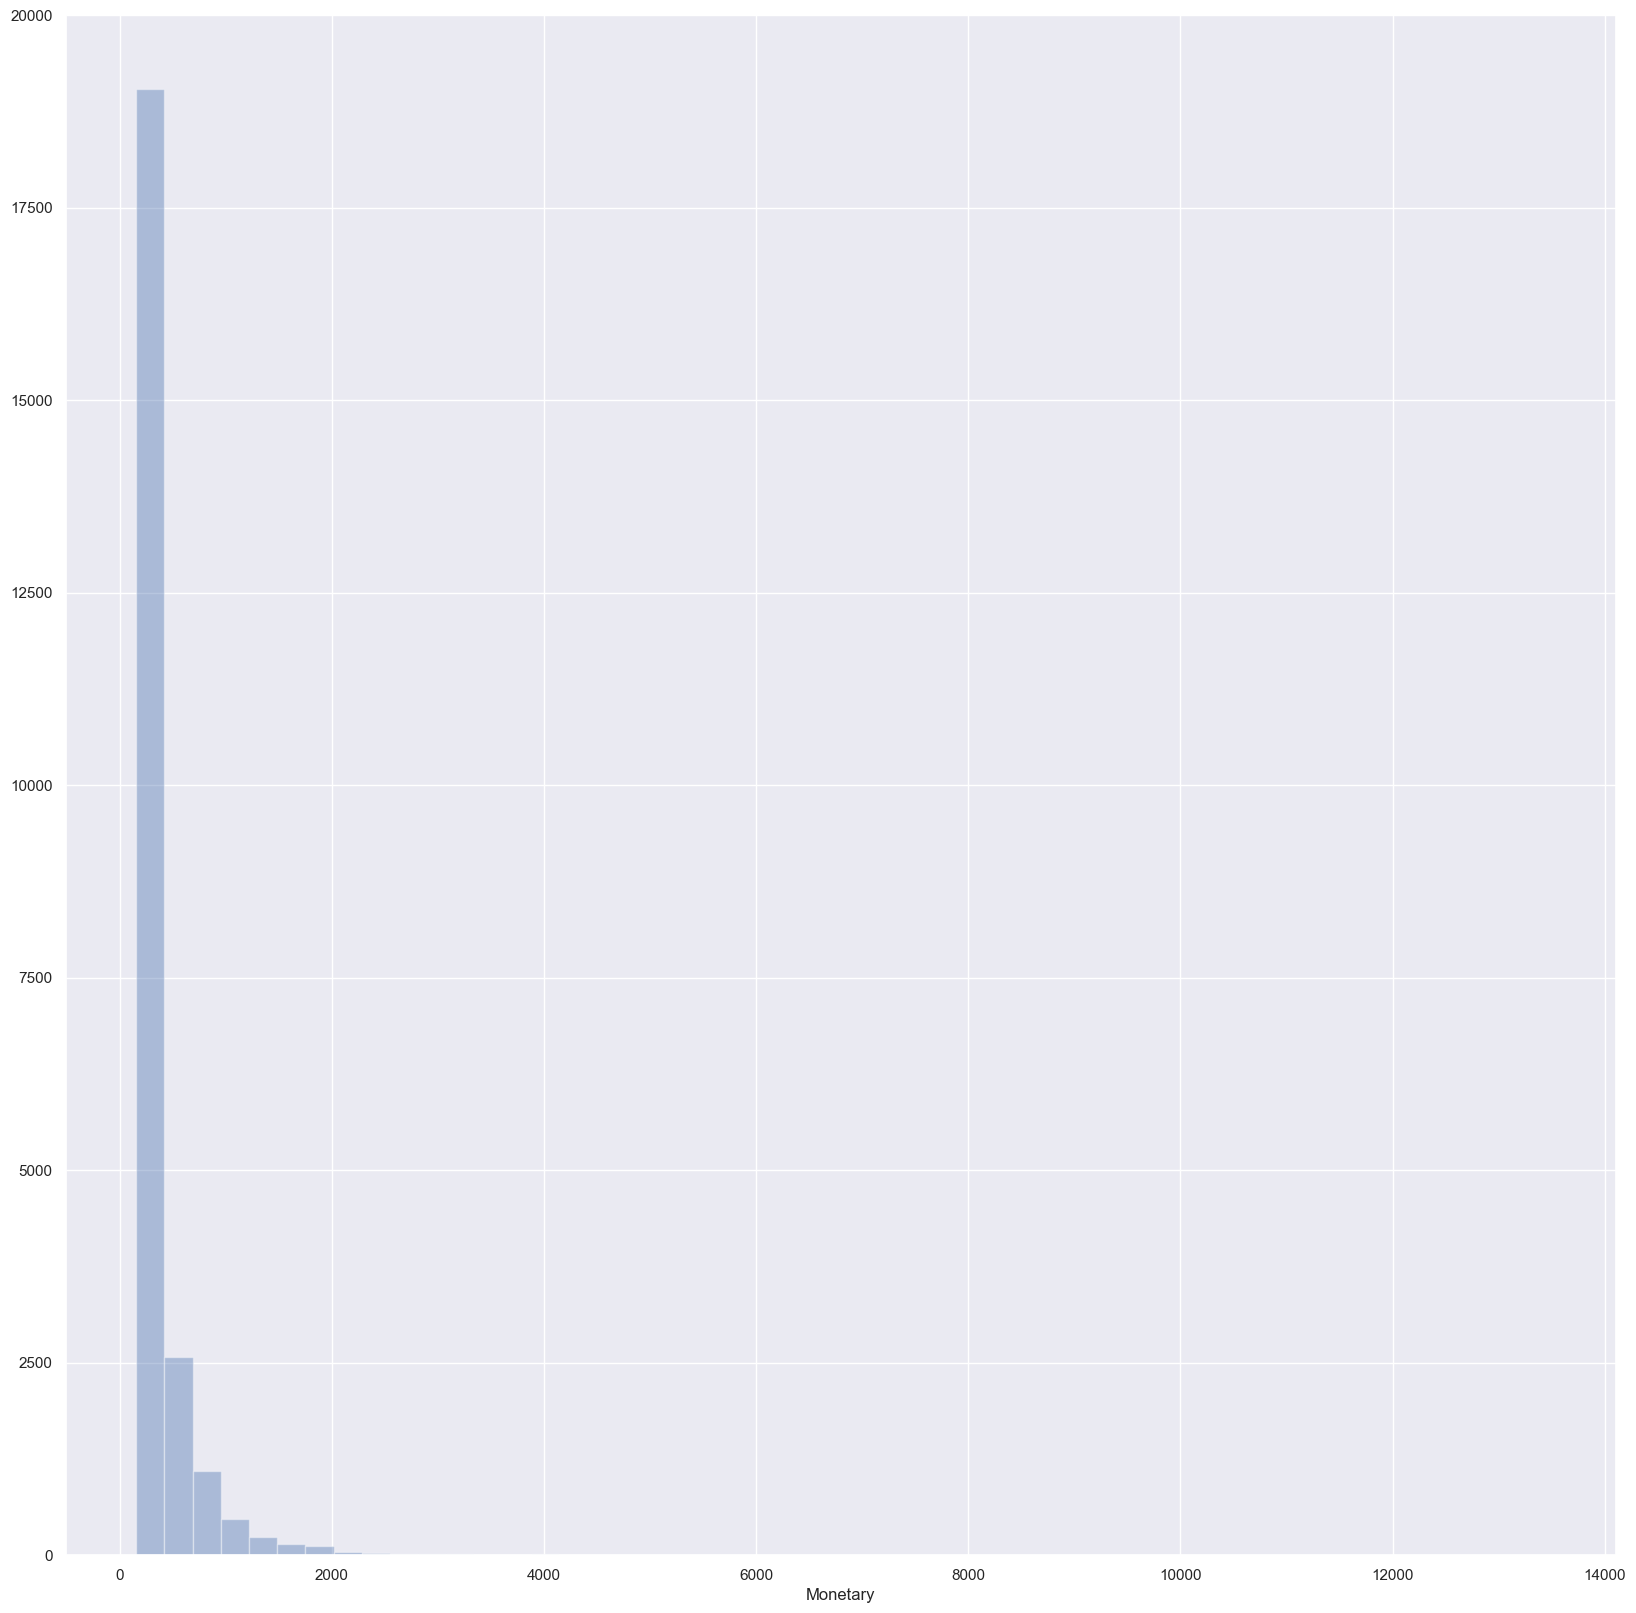

In [81]:
rfm_max = rfm.query('Monetary>155')
sns.distplot(rfm_max.Monetary, kde = False)

In [82]:
rfm_max.Monetary.describe()

count    23833.000000
mean       357.147571
std        351.557451
min        155.060000
25%        189.900000
50%        245.000000
75%        373.800000
max      13440.000000
Name: Monetary, dtype: float64

In [83]:
rfm_max_1 = rfm.query('Monetary>155 & Monetary<2000')
rfm_max_1.Monetary.describe()

count    23681.000000
mean       340.644284
std        265.430565
min        155.060000
25%        189.800000
50%        242.010000
75%        369.900000
max       1999.990000
Name: Monetary, dtype: float64

C:\Users\anna1\AppData\Local\Temp\ipykernel_19168\1318321180.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_max_1.Monetary, kde = False)


<AxesSubplot: xlabel='Monetary'>

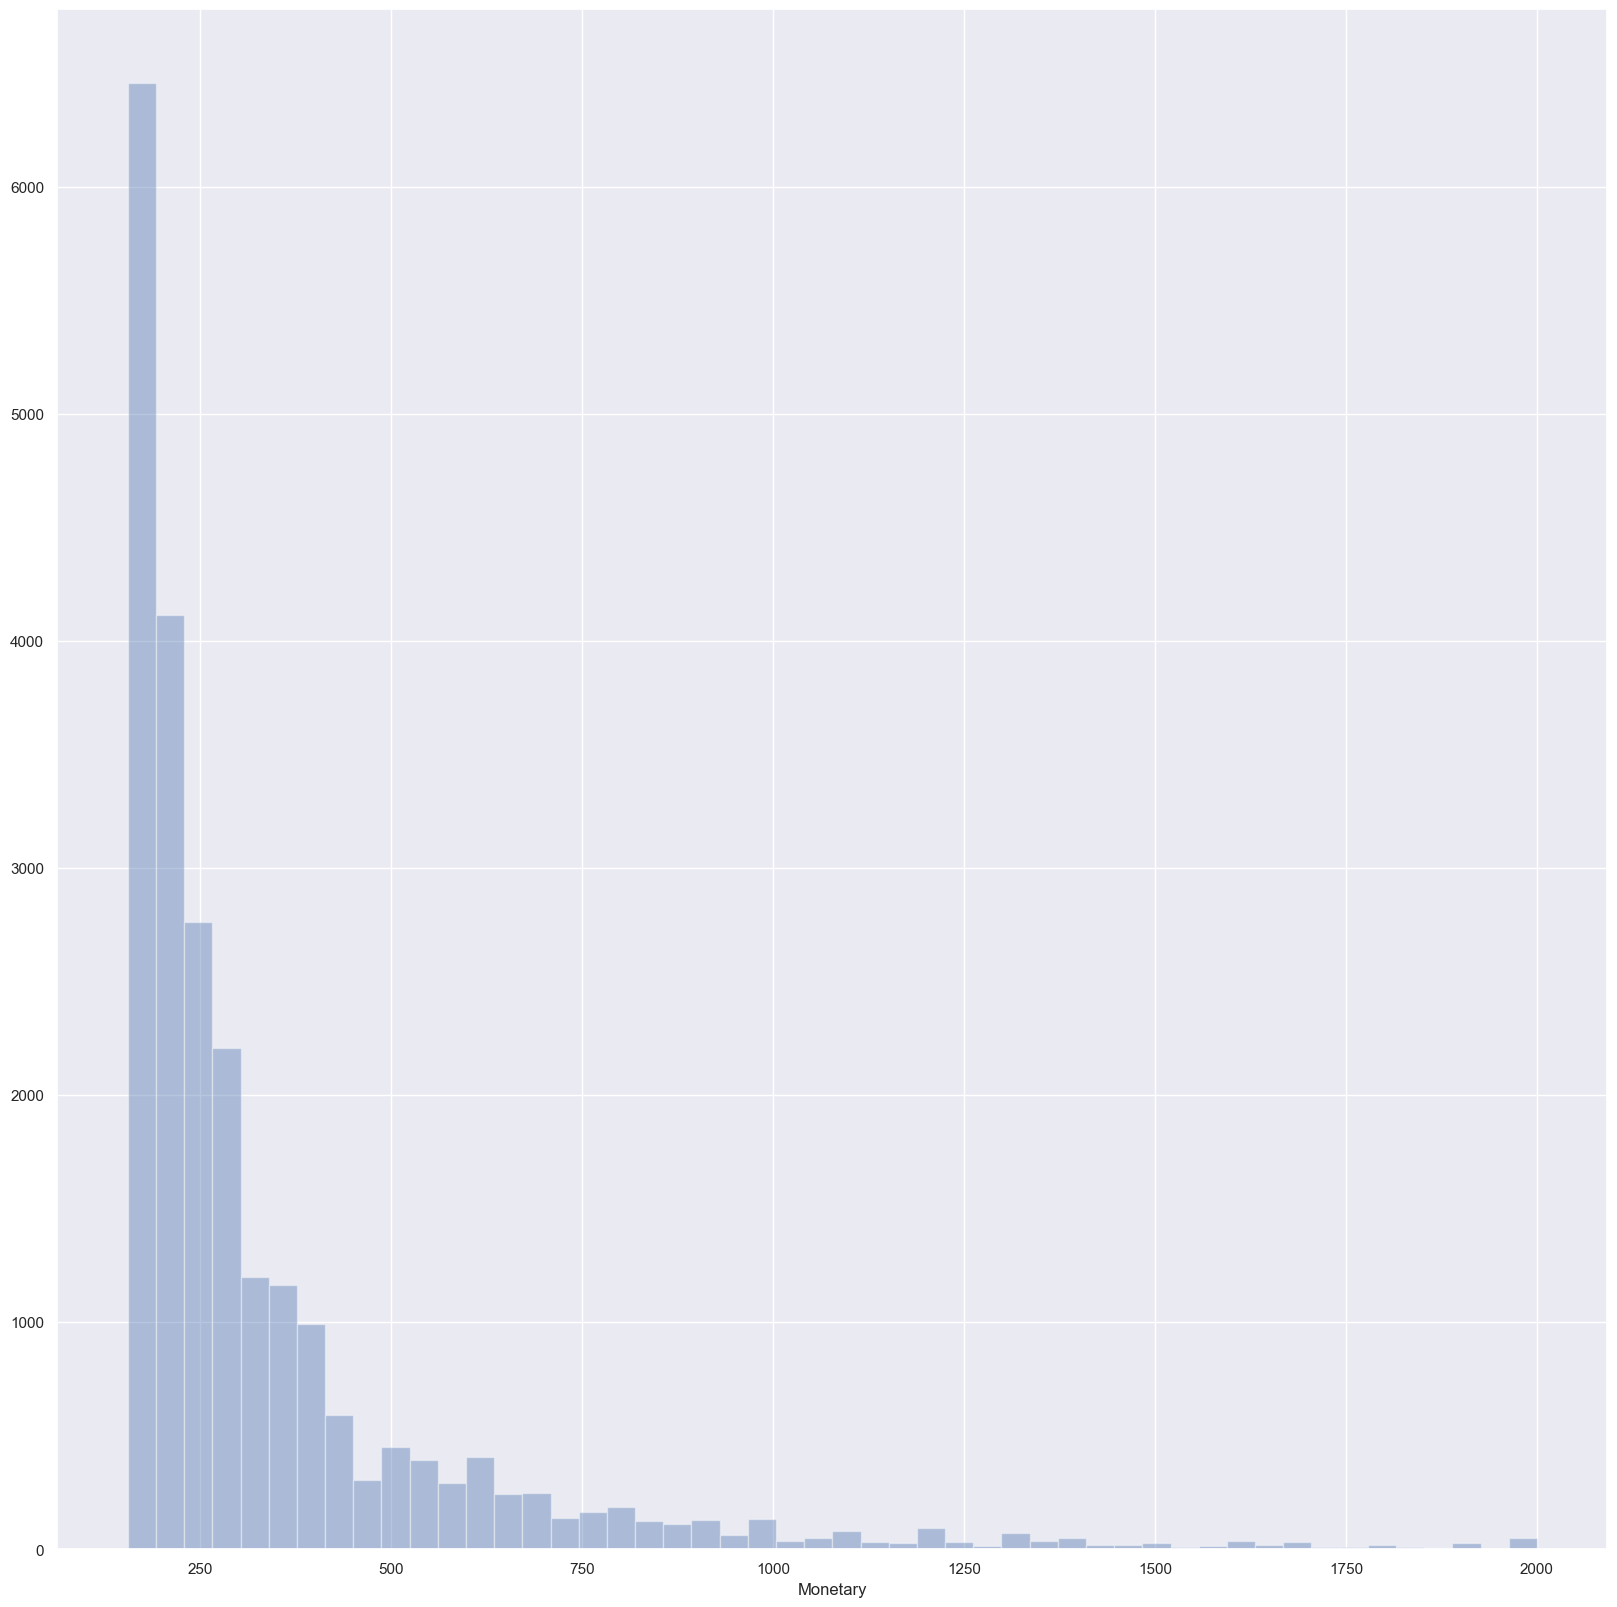

In [84]:
sns.distplot(rfm_max_1.Monetary, kde = False)

<AxesSubplot: ylabel='Monetary'>

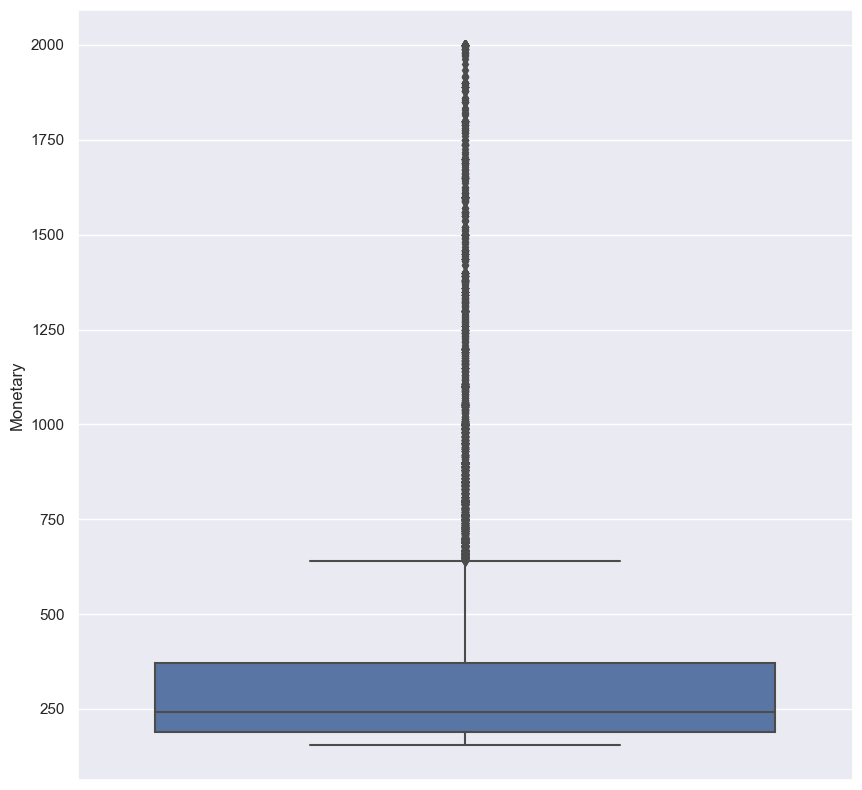

In [85]:
plt.figure(figsize=(10,10))
sns.boxplot(y = rfm_max_1.Monetary)

In [86]:
#Ориентируясь на боксплот и на распределение, выделим еще один кластер из rfm_max, 
#где сосредоточено окло 75% наблюдений, т.е 0,75 квантиль/
#И того получилось 5  сегментов. Так как товары неизвестен, но судя по стоимости, магазин пдает не дорогие товары, 
#поэтому так много значеий сгрппировано в левой части графика и там на небольшой размах так много делений на кластеры

In [87]:
quintile_m_max = rfm_max_1[['Monetary']].quantile([0.75])
quintile_m_max = quintile_m_max.round(-1)

In [88]:
quintile_m_max

,Monetary
0.75,370.0


C:\Users\anna1\AppData\Local\Temp\ipykernel_19168\603368401.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(rfm_mon['Monetary'], kde = False)


<AxesSubplot: xlabel='Monetary'>

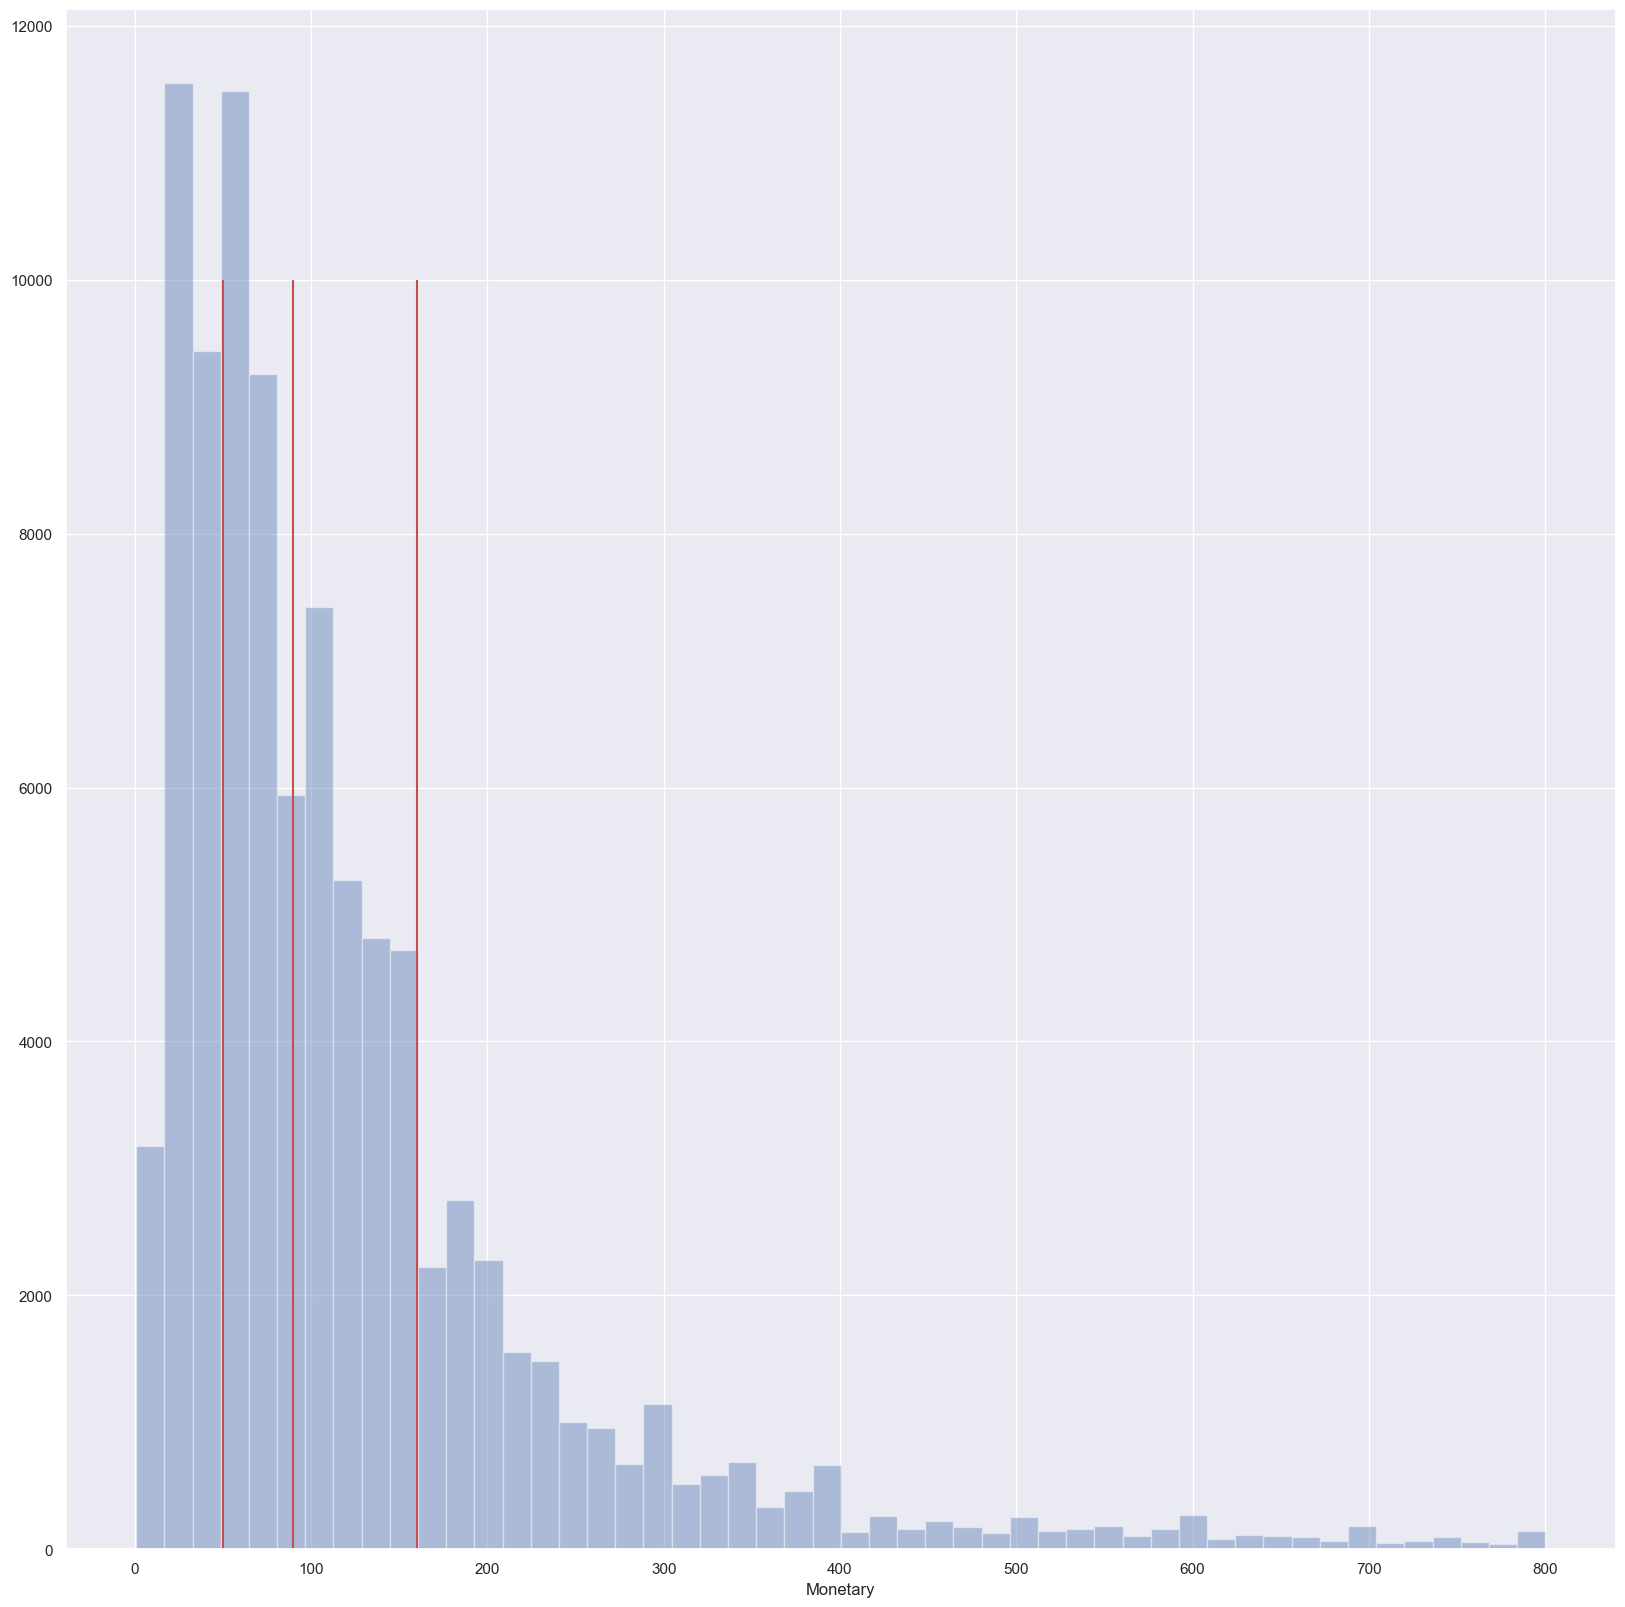

In [89]:
#Построим график с сегментацией и округлением до значений кратных 10
#Покажем на графике только значения до 800, так как все границы сегментов уже видны, но так график выглядит презентабельней
ymin = 0
ymax = 10000
x1 = round(rfm[['Monetary']].quantile([.25]), -1)
x2 = round(rfm[['Monetary']].quantile([.5]), -1)
x3 = round(rfm[['Monetary']].quantile([.75]), -1)
x4 = round(rfm_max_1[['Monetary']].quantile([.75]), -1)
fig, ax = plt.subplots()
ax.vlines(x1, ymin, ymax, color = 'r')
ax.vlines(x2, ymin, ymax, color = 'r')
ax.vlines(x3, ymin, ymax, color = 'r')
rfm_mon = rfm.query('Monetary<800')
sns.distplot(rfm_mon['Monetary'], kde = False)

In [90]:
def m_score(x):
    if x <= quintile_m.Monetary[0.25]:
        return 1
    elif x <= quintile_m.Monetary[0.5]:
        return 2
    elif x <= quintile_m.Monetary[0.75]:
        return 3
    elif x <= quintile_m_max.Monetary[0.75]:
        return 4
    else:
        return 5
    
rfm['M'] = rfm.Monetary.apply(lambda x: m_score(x))

In [91]:
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm

,customer_unique_id,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,4,1,3,413
1,0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,541,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,325,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,292,1,180.00,2,1,4,214
...,...,...,...,...,...,...,...,...
95402,fffcf5a5ff07b0908bd4e2dbc735a684,451,1,1570.00,1,1,5,115
95403,fffea47cd6d3cc0a88bd621562a9d061,266,1,64.89,2,1,2,212
95404,ffff371b4d645b6ecea244b27531430a,573,1,89.90,1,1,2,112
95405,ffff5962728ec6157033ef9805bacc48,124,1,115.00,3,1,3,313


In [92]:
#Recency вычислялась, как время от последней покупки пользователя до последней покупки представленной в данных, 
#так как данные не полные и обрываются ближе к концу 2018, то мы брали не текущую дату, а именно дату последней покупки
#Затем с помощью боксплота и графика распределения оценили выбросы и посмотрели на получившиеся данные. Благодаря этому было
#принято решение выделить кластеры для данных с помощью трех квантилей, которые фигурируют в боксплотет и хорошо описывают 
#данную метрику.

#Frequency вычислялась, как суммарное количество покупок за все время по каждому пользователю. По графику распределения можно отметить,
#что около 85000 пользователей покупали всео один товар, выделим кластер на основании этого наблюдения. Около 9000 покупали 
#2 товара, выделим еще один кластер. И оставшаяся часть покупали 3 и больше товар, это и будет послени кластер.

#Monetary вычисляллась как сумма покупок за все время. В этом случае боксплот и график распределения является не достаточно репрезентативым.
#но при этом судя по бокс-плоту и описанию данных около 50% значений включают общую сумму покупок 50-150 единиц. Поэтому для начала
#выделим триданных квантиля в качетве кластеров. Длее немного отфильтруем данные сначала по значению 0.75 квантиля. 
#Еще раз посмотрим на график распределения, по графику видно, что основная часть оставшихся значений лежит примерно до 2000 единиц.
#Еще раз отфильтруем данные добавив условие <2000. Посмотрим, что 50% данных после фильтра распределеные в диапозоне 190-370, 
#причем если убрать филтр 2000, то эти значения практически не изменятся, исходя из этого выделим еще один кластер, это квантиль
# 0.75 после после всех фильтров.
#
#В RFM_Score 111-это неблагоприятный сегмент для процавца, которые мало купили, также давно не покупли и товар с маленькой стоимостью
#435 - это самый багоприятный сегмент где купили недавно, много и имеют больше всех заказов
#